# Data loading and Preprocessing

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import os

In [3]:
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import gc
import seaborn as sns
import warnings
import scipy.signal as sg
warnings.filterwarnings("ignore")

from scipy import stats

In [5]:
import gc
from itertools import product
import random
import pickle

In [6]:
from xgboost import XGBRegressor
from xgboost import plot_importance

In [7]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max: #and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
def merge_dataset(df):
    
    df = pd.merge(df, shops, on=['shop_id'], how='left')
    df = pd.merge(df, item, on=['item_id'], how='left')
    df = pd.merge(df, item_cat, on=['item_category_id'], how='left')
    df['city_code'] = df['city_code'].astype(np.int8)
    df['item_category_id'] = df['item_category_id'].astype(np.int8)
    df['type_code'] = df['type_code'].astype(np.int8)
    df['subtype_code'] = df['subtype_code'].astype(np.int8)
        
    return df

In [9]:
def target_generate(df):
    df = pd.merge(df, sales_group[['date_block_num','shop_id','item_id','revenue_month','item_cnt_month']], on=cols, how='left')
    df['item_cnt_month'] = (df['item_cnt_month']
                                    .fillna(0)
                                    .clip(0,20) # NB clip target here
                                    .astype(np.float32))
    
    df['revenue_month'] = (df['revenue_month']
                                    .fillna(0)
                                    #.clip(0,20) # NB clip target here
                                    .astype(np.float32))
    return df

In [11]:
lags = np.arange(12) + 1
def lag_feature(df, lags, groupcols = ['shop_id', 'item_id'], col = 'item_cnt_month', fillna = '0'):
    subset = ['date_block_num'] + groupcols
    new_col = '_'.join(groupcols)+'_avg_'+str(col)
    
    group = train_mix.groupby(subset).agg({col: ['mean']})
    group.columns = [new_col]
    group.reset_index(inplace=True)
    
    for i in lags:
        shifted = group.copy()
        shifted.columns = ['date_block_num'] + groupcols + [new_col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=(['date_block_num'] + groupcols), how='left')
        
        if fillna == 'median':
            df[f'{col}_lag_{i}'].fillna(df[new_col+'_lag_'+str(i)].median(), inplace = True)
        elif fillna == 'mean':
            df[f'{col}_lag_{i}'].fillna(df[new_col+'_lag_'+str(i)].mean(), inplace = True)
        elif fillna == '0':
            df.fillna(0, inplace = True)
        del shifted
        gc.collect()    
        
    del group
    
    return df

In [34]:
sales_train = pd.read_csv('./input/sales_train_v2.csv')
test = pd.read_csv('./input/test.csv')

In [35]:
item_cat = pd.read_csv('./input/item_categories.csv')
item= pd.read_csv('./input/items.csv')
shops = pd.read_csv('./input/shops.csv')

In [36]:
def remove_duplicate():
    # Якутск Орджоникидзе, 56
    sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
    test.loc[test.shop_id == 0, 'shop_id'] = 57
    # Якутск ТЦ "Центральный"
    sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
    test.loc[test.shop_id == 1, 'shop_id'] = 58
    # Жуковский ул. Чкалова 39м²
    sales_train.loc[sales_train.shop_id == 10, 'shop_id'] = 11
    test.loc[test.shop_id == 10, 'shop_id'] = 11
    #
    sales_train.loc[sales_train.shop_id == 39, 'shop_id'] = 40
    test.loc[test.shop_id == 39, 'shop_id'] = 40
    
remove_duplicate()

In [37]:
def preprocess_sales_train(df):
    df = df[df['item_cnt_day'] < 1000]
    df = df[df['item_price'] < 100000]
    df = df[df.item_price > 0].reset_index(drop=True)
    df.loc[df.item_cnt_day < 1, 'item_cnt_day'] = 0
    return df

In [38]:
sales_train = preprocess_sales_train(sales_train)
median = sales_train[(sales_train.shop_id==32)&(sales_train.item_id==2973)&(sales_train.date_block_num==4)&(sales_train.item_price>0)].item_price.median()
sales_train.loc[sales_train.item_price<0, 'item_price'] = median

In [39]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['category'] = shops['shop_name'].str.split(' ').map(lambda x:x[1]).astype(str)

shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

category = ['Орджоникидзе,', 'ТЦ', 'ТРК', 'ТРЦ','ул.', 'Магазин', 'ТК', 'склад']
shops.category = shops.category.apply(lambda x: x if (x in category) else 'etc')
shops.category.unique()

array(['Орджоникидзе,', 'ТЦ', 'ТРК', 'ТРЦ', 'etc', 'ул.', 'Магазин', 'ТК',
       'склад'], dtype=object)

In [40]:
category = ['ТЦ', 'ТРК', 'ТРЦ', 'ТК']
shops.category = shops.category.apply(lambda x: x if (x in category) else 'etc')
print('Category Distribution', shops.groupby(['category']).sum())

Category Distribution           shop_id
category         
etc           223
ТК            184
ТРК           140
ТРЦ           340
ТЦ            883


Label encoder is used very frequently to save storage

In [41]:
shops['shop_city'] = shops.city
shops['shop_category'] = shops.category

shops['shop_city'] = LabelEncoder().fit_transform(shops['shop_city'])
shops['shop_category'] = LabelEncoder().fit_transform(shops['shop_category'])

shops = shops[['shop_id','shop_city', 'shop_category']]
shops.head()

,shop_id,shop_city,shop_category
0,0,29,0
1,1,29,4
2,2,0,4
3,3,1,2
4,4,2,4


In [42]:
import re
from collections import Counter
from operator import itemgetter

In [43]:
def name_correction(x):
    x = x.lower()
    x = re.sub("[']+", '', x)
    x = re.sub("[-]+", ' ', x)
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x)
    x = x.replace('  ', ' ')
    x = x.strip()
    return x

item['name_copy'] = item['item_name'].apply(lambda x: name_correction(x))

In [44]:
item['name_copy'] = item.name_copy.str.replace('xbox360', 'xbox 360')
item['name_copy'] = item.name_copy.str.replace('x360', 'xbox 360')
item['name_copy'] = item.name_copy.str.replace('xone', 'xbox one')
item['name_copy'] = item.name_copy.str.replace('xboxone', 'xbox one')

Item name is an important feature. For example if Assasin's creed 1 is popular we can guess Assasin's creed 2 is also popular. One simple way to use name feature is extract part of them.

In [45]:
word_list = item['name_copy'].str.split(' ')
item['name_1'] = word_list.str[0]
item['name_2'] = word_list.str[0] + " " + word_list.str[1]
item['name_3'] = word_list.str[0] + " " + word_list.str[1] + " " +word_list.str[2]
item['name_4'] = word_list.str[0] + " " + word_list.str[1] + " " +word_list.str[2] + " " +word_list.str[3]
item['name_5'] = word_list.str[0] + " " + word_list.str[1] + " " +word_list.str[2] + " " +word_list.str[3] + " " +word_list.str[4]

In [26]:
item.head()

,item_name,item_id,item_category_id,name_copy,name_1,name_2,name_3,name_4,name_5
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,во власти наваждения пласт d,во,во власти,во власти наваждения,во власти наваждения пласт,во власти наваждения пласт d
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,abbyy finereader 12 professional edition full ...,abbyy,abbyy finereader,abbyy finereader 12,abbyy finereader 12 professional,abbyy finereader 12 professional edition
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,в лучах славы unv d,в,в лучах,в лучах славы,в лучах славы unv,в лучах славы unv d
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,голубая волна univ d,голубая,голубая волна,голубая волна univ,голубая волна univ d,NaN
4,***КОРОБКА (СТЕКЛО) D,4,40,коробка стекло d,коробка,коробка стекло,коробка стекло d,NaN,NaN


In [46]:
item.loc[item['name_2'].isnull(),'name_2'] = item.loc[item['name_2'].isnull(),'name_1']
item.loc[item['name_3'].isnull(),'name_3'] = item.loc[item['name_3'].isnull(),'name_2']
item.loc[item['name_4'].isnull(),'name_4'] = item.loc[item['name_4'].isnull(),'name_3']
item.loc[item['name_5'].isnull(),'name_5'] = item.loc[item['name_5'].isnull(),'name_4']

In [28]:
item.head()

,item_name,item_id,item_category_id,name_copy,name_1,name_2,name_3,name_4,name_5
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,во власти наваждения пласт d,во,во власти,во власти наваждения,во власти наваждения пласт,во власти наваждения пласт d
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,abbyy finereader 12 professional edition full ...,abbyy,abbyy finereader,abbyy finereader 12,abbyy finereader 12 professional,abbyy finereader 12 professional edition
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,в лучах славы unv d,в,в лучах,в лучах славы,в лучах славы unv,в лучах славы unv d
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,голубая волна univ d,голубая,голубая волна,голубая волна univ,голубая волна univ d,голубая волна univ d
4,***КОРОБКА (СТЕКЛО) D,4,40,коробка стекло d,коробка,коробка стекло,коробка стекло d,коробка стекло d,коробка стекло d


In [47]:
item['name_1'] = item['name_1'].astype('str')
item['name_2'] = item['name_2'].astype('str')
item['name_3'] = item['name_3'].astype('str')
item['name_4'] = item['name_4'].astype('str')
item['name_5'] = item['name_5'].astype('str')

There are some keywords repeatily showing up in the item names. They can be used as features

In [48]:
item['language'] = -1
item.loc[item['name_copy'].str.contains('русс'),'language'] = 0
item.loc[item['name_copy'].str.contains('англий'), 'language']=1
item['language'] = item['language'].astype(np.int8)

In [49]:
item['isbd'] = 0
item.loc[item['name_copy'].str.contains('bd'),'isbd'] = 1
item['isрегион'] = 0
item.loc[item['name_copy'].str.contains('регион'),'isрегион'] = 1
item['isjewel'] = 0
item.loc[item['name_copy'].str.contains('jewel'),'isjewel'] = 1
item['isdigital'] = 0
item.loc[(item['name_copy'].str.contains('digi'))|(item['name_copy'].str.contains('цифро')),'isdigital']=1

In [50]:
item['console'] = -1
consoles = ['pc', 'xbox', 'xbox 360', 'xbox one', 'ps', 'ps3', 'ps4']
count = 0
for console in consoles:
    item.loc[item['name_copy'].str.contains(console),'console'] = count
    count = count + 1

In [51]:
formats = ['cd', 'dvd', 'mp3', 'lp']
for format in formats:
    feature = f'has_{format}'
    item[feature] = 0
    item.loc[item['name_copy'].str.contains(format),feature]=1

Version is a feature shared among different items. Basically it's determined by price

In [52]:
item['version'] = -1

In [53]:
#'game version'
versions = []
versions.append(['basic','essential','standard'])
versions.append(['classics','exclusive','special','season','специальное'])
versions.append(['deluxe', 'limited'])
versions.append(['gold edition','premium'])
versions.append(['ultimate edition'])
versions.append(['collector', 'legendary', 'коллекционное'])
versions.append(['допол','add','dlc', 'pack', 'расширенное'])
versions.append(['пред']) # pre-order

for i in range(8):
    item.loc[(item['item_category_id']>=18) 
             & (item['item_category_id']<32) 
             & (item['name_copy'].str.contains('|'.join(versions[i])))
             & (item['version']==-1), 'version'] = i
                                                                                        

In [54]:
item.loc[item['version']==-1, 'version'] = 0

In [33]:
item.head()

,item_name,item_id,item_category_id,name_copy,name_1,name_2,name_3,name_4,name_5,language,isbd,isрегион,isjewel,isdigital,console,has_cd,has_dvd,has_mp3,has_lp,version
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,во власти наваждения пласт d,во,во власти,во власти наваждения,во власти наваждения пласт,во власти наваждения пласт d,-1,0,0,0,0,-1,0,0,0,0,-1
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,abbyy finereader 12 professional edition full ...,abbyy,abbyy finereader,abbyy finereader 12,abbyy finereader 12 professional,abbyy finereader 12 professional edition,-1,0,0,0,1,0,0,0,0,0,-1
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,в лучах славы unv d,в,в лучах,в лучах славы,в лучах славы unv,в лучах славы unv d,-1,0,0,0,0,-1,0,0,0,0,-1
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,голубая волна univ d,голубая,голубая волна,голубая волна univ,голубая волна univ d,nan,-1,0,0,0,0,-1,0,0,0,0,-1
4,***КОРОБКА (СТЕКЛО) D,4,40,коробка стекло d,коробка,коробка стекло,коробка стекло d,nan,nan,-1,0,0,0,0,-1,0,0,0,0,-1


In [35]:
item['name_1'] = LabelEncoder().fit_transform(item['name_1'])
item['name_2'] = LabelEncoder().fit_transform(item['name_2'])
item['name_3'] = LabelEncoder().fit_transform(item['name_3'])
item['name_4'] = LabelEncoder().fit_transform(item['name_4'])
item['name_5'] = LabelEncoder().fit_transform(item['name_5'])
item.drop(['item_name', 'name_copy'], axis=1, inplace=True)
item.head()

,item_id,item_category_id,name_1,name_2,name_3,name_4,name_5,language,isbd,isрегион,isjewel,isdigital,console,has_cd,has_dvd,has_mp3,has_lp,version
0,0,40,1577,3228,5504,7006,8186,-1,0,0,0,0,-1,0,0,0,0,-1
1,1,76,53,157,439,678,826,-1,0,0,0,1,0,0,0,0,0,-1
2,2,40,1477,2979,5163,6598,7723,-1,0,0,0,0,-1,0,0,0,0,-1
3,3,40,1730,3548,5951,7508,8731,-1,0,0,0,0,-1,0,0,0,0,-1
4,4,40,2367,4906,7762,9629,11058,-1,0,0,0,0,-1,0,0,0,0,-1


In [56]:
item_cat['type_code'] = item_cat.item_category_name.apply(lambda x: x.split(' ')[0]).astype(str)
item_cat.loc[(item_cat.type_code == 'Игровые') | (item_cat.type_code == 'Аксессуары'), 'category'] = 'Игры'
item_cat.loc[item_cat.type_code == 'PC', 'category'] = 'Музыка'

category = ['Игры', 'Карты', 'Кино', 'Книги','Музыка', 'Подарки', 'Программы', 'Служебные', 'Чистые']

item_cat['type_code'] = item_cat.type_code.apply(lambda x: x if (x in category) else 'etc')

print(item_cat.groupby(['type_code']).sum())


item_cat['split'] = item_cat.item_category_name.apply(lambda x: x.split('-'))
item_cat['subtype'] = item_cat['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())

           item_category_id
type_code                  
etc                     236
Игры                    343
Карты                   170
Кино                    195
Книги                   624
Музыка                  345
Подарки                 798
Программы               453
Служебные               159
Чистые                  163


In [ ]:
item_cat['type_code'] = LabelEncoder().fit_transform(item_cat['type_code'])
item_cat['subtype_code'] = LabelEncoder().fit_transform(item_cat['subtype'])
item_cat = item_cat[['item_category_id','type_code', 'subtype_code']]

In [57]:
l_cat = list(item_cat.item_category_id)

In [58]:
for ind in range(0,1):

     l_cat[ind] = 'PC Headsets / Headphones'

for ind in range(1,8):

     l_cat[ind] = 'Access'

l_cat[8] = 'Tickets (figure)'

l_cat[9] = 'Delivery of goods'

for ind in range(10,18):

    l_cat[ind] = 'Consoles'

for ind in range(18,25):

    l_cat[ind] = 'Consoles Games'

l_cat[25] = 'Accessories for games'

for ind in range(26,28):

    l_cat[ind] = 'phone games'

for ind in range(28,32):

    l_cat[ind] = 'CD games'

for ind in range(32,37):

    l_cat[ind] = 'Card'

for ind in range(37,43):

    l_cat[ind] = 'Movie'

for ind in range(43,55):

    l_cat[ind] = 'Books'

for ind in range(55,61):

    l_cat[ind] = 'Music'

for ind in range(61,73):

    l_cat[ind] = 'Gifts'

for ind in range(73,79):

    l_cat[ind] = 'Soft'

for ind in range(79,81):

    l_cat[ind] = 'Office'

for ind in range(81,83):

    l_cat[ind] = 'Clean'

l_cat[83] = 'Elements of a food'

In [39]:
from sklearn import preprocessing

lb = preprocessing.LabelEncoder()
item_cat['item_cat_id_fix'] = lb.fit_transform(l_cat)

In [104]:
sales_train['revenue'] = sales_train['item_price'] *  sales_train['item_cnt_day']

In [105]:
gc.collect()

148

In [106]:
sales_train = reduce_mem_usage(sales_train)

Mem. usage decreased to 67.20 Mb (57.1% reduction)


# Categorize test and validation data set

In [107]:
cols = ['date_block_num','shop_id','item_id']

In [108]:
test['date_block_num']= 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test = test[cols]

In [109]:
sales_group = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({
                                    'item_cnt_day': ['sum'],
                                    'revenue': ['sum']
})

In [110]:
sales_group.columns = ['_'.join(col).strip() for col in sales_group.columns.values]
sales_group.rename(columns = {
                            'revenue_sum': 'revenue_month',
                            'item_cnt_day_sum': 'item_cnt_month',
                            },
                 inplace = True) 
sales_group.reset_index(inplace=True)

In [111]:
cols = [col for col in item.columns.values if col not in ['item_name', 'name_copy']]
sales_group = pd.merge(sales_group, item[cols], on = ['item_id'], how = 'left')

In [112]:
sales_group.head()

,date_block_num,shop_id,item_id,item_cnt_month,revenue_month,item_category_id,name_1,name_2,name_3,name_4,...,isbd,isрегион,isjewel,isdigital,console,has_cd,has_dvd,has_mp3,has_lp,version
0,0,2,27,1.0,2499.0,19,007,007 legends,007 legends ps3,007 legends ps3 русская,...,0,0,0,0,5,0,0,0,0,-1
1,0,2,33,1.0,499.0,37,1,1 1,1 1 bd,1 1 bd,...,1,0,0,0,-1,0,0,0,0,-1
2,0,2,317,1.0,299.0,45,1с,1с аудиокниги,1с аудиокниги мединский,1с аудиокниги мединский в,...,0,0,0,1,-1,0,1,0,0,-1
3,0,2,438,1.0,299.0,45,1с,1с аудиотеатр,1с аудиотеатр лучшие,1с аудиотеатр лучшие произведения,...,0,0,0,1,-1,0,1,0,0,-1
4,0,2,471,2.0,798.0,49,1с,1с бухгалтерия,1с бухгалтерия 8,1с бухгалтерия 8 ред,...,0,0,0,0,-1,0,0,0,0,-1


Initialize category column, 4 means haven't assigned any tag

In [56]:
test['category'] = 4

In [57]:
shop_train = sales_group.loc[sales_group['date_block_num']<=33]['shop_id'].unique()
item_lst = sales_group.loc[sales_group['date_block_num']<=33]['item_id'].unique()
shop_test = test.loc[test['category']==0]['shop_id'].unique()

In [58]:
len(test.loc[test['category']==0]), len(test.loc[test['category']==1]), len(test.loc[test['category']==2])

(0, 0, 0)

In [59]:
test.head()

,date_block_num,shop_id,item_id,category
0,34,5,5037,4
1,34,5,5320,4
2,34,5,5233,4
3,34,5,5232,4
4,34,5,5268,4


In [41]:
sales_group['date_block_num'].max()

33

Normal items with shop and item in sale history

In [60]:
for shop in shop_train:
    item_lst_shop = sales_group.loc[(sales_group['date_block_num']<=33)&(sales_group['shop_id'] == shop)]['item_id'].unique()
    test.loc[(test['shop_id'] == shop) & (test['item_id'].isin(item_lst_shop)), 'category'] = 0

Items w/o sale history in train data.

In [61]:
test.loc[~(test['item_id'].isin(item_lst)), 'category'] = 2

Items w sale history but not in a particular shop

In [62]:
test.loc[test['category'] == 4, 'category'] = 1

In [46]:
len(test.loc[test['category']==0]), len(test.loc[test['category']==1]), len(test.loc[test['category']==2])

(111511, 87443, 15246)

In [44]:
with open('df_prediction_20191031.pickle', 'wb') as handle:
    pickle.dump(test, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('df_prediction_20191031.pickle', 'rb') as handle:
    test = pickle.load(handle)

# Data preparation

In [63]:
cols = ['date_block_num','shop_id','item_id']

Training data should be generated from sale history (all nonzero) padded with 0 sale record. The test set is generated by shop * item. That is too much data for training set. Instead, the training set is generated by (shop in a month) * (items in a month)

In [64]:
train_mix = []
for i in range(34):
    sales = sales_train[sales_train.date_block_num==i]
    train_mix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
train_mix = pd.DataFrame(np.vstack(train_mix), columns=cols)
train_mix['date_block_num'] = train_mix['date_block_num'].astype(np.int8)
train_mix['shop_id'] = train_mix['shop_id'].astype(np.int8)
train_mix['item_id'] = train_mix['item_id'].astype(np.int16)
train_mix.sort_values(cols,inplace=True)

In [49]:
gc.collect()

21

In [65]:
train_mix['category'] = 4

In [66]:
train_mix = pd.concat([train_mix, test], ignore_index=True, sort=False, keys=cols)
train_mix.fillna(0, inplace=True) # 34 month

In [67]:
train_mix = target_generate(train_mix)

In [75]:
def merge_dataset(df):
    
    df = pd.merge(df, shops[['shop_id','shop_city','shop_category']], on=['shop_id'], how='left')
    df = pd.merge(df, item, on=['item_id'], how='left')
    df = pd.merge(df, item_cat[['item_category_id','type_code','subtype_code','item_cat_id_fix']], on=['item_category_id'], how='left')
      
    return df

In [76]:
train_mix = merge_dataset(train_mix)

Change data type of columns to save space as much as possible

In [77]:
train_mix['shop_city'] = train_mix['shop_city'].astype(np.int8)
train_mix['shop_category'] = train_mix['shop_category'].astype(np.int8)
train_mix['item_category_id'] = train_mix['item_category_id'].astype(np.int8)
train_mix['type_code'] = train_mix['type_code'].astype(np.int8)
train_mix['subtype_code'] = train_mix['subtype_code'].astype(np.int8)
gc.collect()

70

In [114]:
ts = time.time()

lags = [1,2,3,6]
groupcols = ['shop_id','item_id']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float16)

time.time() - ts

8.782300472259521

In [121]:
ts = time.time()

lags = [1,2,3,6]
groupcols = ['shop_id','item_id']
col = 'revenue_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float32)

time.time() - ts

0.35834717750549316

In [61]:
len(train_mix.loc[(train_mix['date_block_num'] < 34) & (train_mix['item_cnt_month']==0)])/len(train_mix.loc[(train_mix['date_block_num'] < 34)])

0.8517468562527272

Categorize data in train_mix. (This way is not actually correct)

In [84]:
for shop in shop_train:
    item_lst_shop = sales_group.loc[(sales_group['date_block_num']<=33)&(sales_group['shop_id'] == shop)]['item_id'].unique()
    train_mix.loc[(train_mix['shop_id'] == shop) & (train_mix['item_id'].isin(item_lst_shop)), 'category'] = 0

In [85]:
train_mix.loc[~(train_mix['item_id'].isin(item_lst)), 'category'] = 2

In [86]:
train_mix.loc[train_mix['category'] == 4, 'category'] = 1

In [58]:
train_mix.columns.to_series()[np.isinf(train_mix).any()]

Series([], dtype: object)

# Feature Engineering

Lag features

In [122]:
ts = time.time()

lags = [1,2,3,6,12]
groupcols = []
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float16)

time.time() - ts

9.6251220703125

In [123]:
ts = time.time()

lags = [1,2,3,6]
groupcols = []
col = 'revenue_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float32)

time.time() - ts

0.2973592281341553

In [124]:
ts = time.time()

lags = [1,2,3,6]
groupcols = ['item_id']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float16)

time.time() - ts

7.278248071670532

In [125]:
ts = time.time()

lags = [1,2,3,6]
groupcols = ['shop_id']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float16)

time.time() - ts

6.718816041946411

In [ ]:
ts = time.time()

lags = [1,2,3,12]
groupcols = ['name_1']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float16)

time.time() - ts

In [126]:
ts = time.time()

lags = [1,2,3,12]
groupcols = ['name_2']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float16)

time.time() - ts

6.194637775421143

In [127]:
ts = time.time()

lags = [1,2,3,12]
groupcols = ['name_3']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float16)

time.time() - ts

5.8112876415252686

In [128]:
ts = time.time()

lags = [1,2,3,12]
groupcols = ['name_4']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float16)

time.time() - ts

5.301374912261963

In [ ]:
ts = time.time()

lags = [1,2,3,12]
groupcols = ['shop_id','name_1']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float16)

time.time() - ts

In [129]:
ts = time.time()

lags = [1,2,3,12]
groupcols = ['shop_id','name_2']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float16)

time.time() - ts

4.819436311721802

In [130]:
ts = time.time()

lags = [1,2,3,12]
groupcols = ['shop_id','name_3']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float16)

time.time() - ts

4.313985347747803

In [131]:
ts = time.time()

lags = [1,2,3,12]
groupcols = ['shop_id','name_4']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float16)

time.time() - ts

3.8822169303894043

In [132]:
ts = time.time()

lags = [1,2,3]
groupcols = ['shop_id']
col = 'revenue_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float32)

time.time() - ts

0.19908690452575684

In [133]:
ts = time.time()

lags = [1]
groupcols = ['item_category_id']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float16)

time.time() - ts

0.875999927520752

In [76]:
ts = time.time()

lags = [1]
groupcols = ['item_category_id']
col = 'revenue_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float32)

time.time() - ts

37.51976799964905

In [134]:
ts = time.time()

lags = [1]
groupcols = ['shop_id','item_category_id']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float16)

time.time() - ts

0.8551521301269531

In [78]:
ts = time.time()

lags = [1]
groupcols = ['shop_id','item_category_id']
col = 'revenue_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float32)

time.time() - ts

43.63514995574951

In [135]:
ts = time.time()

lags = [1]
groupcols = ['shop_id','type_code']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float16)

time.time() - ts

0.8205060958862305

In [80]:
ts = time.time()

lags = [1]
groupcols = ['shop_id','type_code']
col = 'revenue_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float32)
    
time.time() - ts

49.02784562110901

In [136]:
ts = time.time()

lags = [1]
groupcols = ['shop_id','subtype_code']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float16)

time.time() - ts

0.8017592430114746

In [82]:
ts = time.time()

lags = [1]
groupcols = ['shop_id','subtype_code']
col = 'revenue_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float32)

time.time() - ts

53.45315194129944

In [137]:
ts = time.time()

lags = [1]
groupcols = ['shop_city']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float16)

time.time() - ts

0.7515969276428223

In [138]:
ts = time.time()

lags = [1]
groupcols = ['shop_city']
col = 'revenue_month'
#train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float32)

time.time() - ts

0.08196759223937988

In [139]:
ts = time.time()

lags = [1,2,3,6,12]
groupcols = ['shop_city','item_id']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float16)

time.time() - ts

3.423837184906006

In [140]:
ts = time.time()

lags = [1,2,3,6,12]
groupcols = ['type_code']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float16)

time.time() - ts

2.5642189979553223

In [141]:
ts = time.time()

lags = [1]
groupcols = ['type_code']
col = 'revenue_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float32)

time.time() - ts

0.08389639854431152

In [142]:
ts = time.time()

lags = [1]
groupcols = ['subtype_code']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float16)

time.time() - ts

0.43639588356018066

In [143]:
ts = time.time()

lags = [1]
groupcols = ['subtype_code']
col = 'revenue_month'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float32)
    
time.time() - ts

0.08698391914367676

In [110]:
gc.collect()

14

Follow the idea and do more item_price feature engineering

In [ ]:
def select_value(row, feature, lags):
    for i in lags:
        if row[f'{feature}_lag_{i}']:
            return row[f'{feature}_lag_{i}']
    return 0

In [ ]:
ts = time.time()
group = sales_train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['item_id'], how='left')
train_mix['item_avg_item_price'] = train_mix['item_avg_item_price'].astype(np.float16)

group = sales_train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num','item_id'], how='left')
train_mix['date_item_avg_item_price'] = train_mix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6,7,8,9,10,11,12]
groupcols = ['item_id']
col = 'date_item_avg_item_price'
train_mix = lag_feature(train_mix,lags,groupcols,col)
new_col = '_'.join(groupcols)+'_avg_'+str(col)

for i in lags:
    train_mix['delta_price_lag_'+str(i)] = \
        (train_mix[f'{new_col}_lag_'+str(i)] - train_mix['item_avg_item_price']) / train_mix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if np.isnan(row['delta_price_lag_'+str(i)]):
            continue
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
train_mix['delta_price_lag'] = train_mix.apply(select_trend, axis=1)
train_mix['delta_price_lag'] = train_mix['delta_price_lag'].astype(np.float16)
train_mix['delta_price_lag'].fillna(0, inplace=True)

features_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    features_to_drop += [f'{new_col}_lag_'+str(i)]
    features_to_drop += ['delta_price_lag_'+str(i)]

train_mix.drop(features_to_drop, axis=1, inplace=True)

time.time() - ts

In [145]:
ts = time.time()

group = sales_train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_price']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num','item_id'], how='left')
train_mix['date_item_avg_price'] = train_mix['date_item_avg_price'].astype(np.float16)

lags = [1,2,3,4,5,6,7,8,9,10,11,12]
groupcols = ['item_id']
col = 'date_item_avg_price'
train_mix = lag_feature(train_mix,lags,groupcols,col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)

def select_value(row):
    for i in lags:
        if np.isnan(row[f'{new_col}_lag_'+str(i)]):
            continue
        if row[f'{new_col}_lag_'+str(i)]:
            return row[f'{new_col}_lag_'+str(i)]
    return 0

train_mix['last_item_avg_price'] = train_mix.apply(select_value, axis=1)
train_mix['last_item_avg_price'] = train_mix['last_item_avg_price'].astype(np.float16)
train_mix['last_item_avg_price'].fillna(0, inplace=True)

gc.collect()

features_to_drop = ['date_item_avg_price']
for i in lags:
    features_to_drop += [f'{new_col}_lag_'+str(i)]
train_mix.drop(features_to_drop, axis=1, inplace=True)

time.time() - ts

650.6100630760193

In [146]:
ts = time.time()

group = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_shop_item_avg_price']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num','shop_id','item_id'], how='left')
train_mix['date_shop_item_avg_price'] = train_mix['date_shop_item_avg_price'].astype(np.float16)

lags = [1,2,3,4,5,6,7,8,9,10,11,12]
groupcols = ['shop_id','item_id']
col = 'date_shop_item_avg_price'
train_mix = lag_feature(train_mix,lags,groupcols,col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)

def select_value(row):
    for i in lags:
        if np.isnan(row[f'{new_col}_lag_'+str(i)]):
            continue
        if row[f'{new_col}_lag_'+str(i)]:
            return row[f'{new_col}_lag_'+str(i)]
    return 0

train_mix['last_shop_item_avg_price'] = train_mix.apply(select_value, axis=1)
train_mix['last_shop_item_avg_price'] = train_mix['last_shop_item_avg_price'].astype(np.float16)
train_mix['last_shop_item_avg_price'].fillna(0, inplace=True)

gc.collect()

fetures_to_drop = ['date_shop_item_avg_price']
for i in lags:
    fetures_to_drop += [f'{new_col}_lag_'+str(i)]
train_mix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

1982.9437563419342

In [147]:
train_mix['last_price_diff'] = train_mix['last_shop_item_avg_price'] - train_mix['last_item_avg_price']
train_mix['last_price_ratio'] = train_mix['last_shop_item_avg_price'] / train_mix['last_item_avg_price']
train_mix['last_price_ratio'].replace([np.inf, -np.inf], 0, inplace = True)

In [ ]:
def merge_dataset(df):
    
    df = pd.merge(df, shops[['shop_id','shop_city','shop_category']], on=['shop_id'], how='left')
    df = pd.merge(df, item[['item_id','item_category_id','name_2','name_3']], on=['item_id'], how='left')
    df = pd.merge(df, item_cat[['item_category_id','type_code','subtype_code','item_cat_id_fix']], on=['item_category_id'], how='left')
      
    return df

In [103]:
sales_train = merge_dataset(sales_train)
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue,shop_city,shop_category,item_category_id,name_2,name_3,type_code,subtype_code,item_cat_id_fix
0,02.01.2013,0,59,22154,999.000000000000,1.0,999.000000000000,30,4,37,0,562,3,1,11
1,03.01.2013,0,25,2552,899.000000000000,1.0,899.000000000000,13,2,58,0,42,5,27,12
2,05.01.2013,0,25,2552,899.000000000000,0.0,0.000000000000,13,2,58,0,42,5,27,12
3,06.01.2013,0,25,2554,1709.050048828125,1.0,1709.050048828125,13,2,58,0,42,5,27,12
4,15.01.2013,0,25,2555,1099.000000000000,1.0,1099.000000000000,13,2,56,0,1632,5,3,12


In [ ]:
ts = time.time()

group = sales_train.groupby(['date_block_num','item_category_id']).agg({'item_price': ['mean']})
group.columns = ['date_cat_avg_price']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num','item_category_id'], how='left')
train_mix['date_cat_avg_price'] = train_mix['date_cat_avg_price'].astype(np.float16)

del group
gc.collect()

lags = [1,2,3,4,5,6,7,8,9,10,11,12]
groupcols = ['item_category_id']
col = 'date_cat_avg_price'
train_mix = lag_feature(train_mix,lags,groupcols,col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)

def select_value(row):
    for i in lags:
        if np.isnan(row[f'{new_col}_lag_'+str(i)]):
            continue
        if row[f'{new_col}_lag_'+str(i)]:
            return row[f'{new_col}_lag_'+str(i)]
    return 0

train_mix['last_cat_avg_price'] = train_mix.apply(select_value, axis=1)
train_mix['last_cat_avg_price'] = train_mix['last_cat_avg_price'].astype(np.float16)
train_mix['last_cat_avg_price'].fillna(0, inplace=True)

fetures_to_drop = ['date_cat_avg_price']
for i in lags:
    fetures_to_drop += [f'{new_col}_lag_'+str(i)]

train_mix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

In [ ]:
ts = time.time()

group = sales_train.groupby(['date_block_num','shop_id']).agg({'item_price': ['mean']})
group.columns = ['date_shop_avg_price']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num','shop_id'], how='left')
train_mix['date_shop_avg_price'] = train_mix['date_shop_avg_price'].astype(np.float16)

del group
gc.collect()

lags = [1,2,3,4,5,6,7,8,9,10,11,12]
groupcols = ['shop_id']
col = 'date_shop_avg_price'
train_mix = lag_feature(train_mix,lags,groupcols,col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)


def select_value(row):
    for i in lags:
        if np.isnan(row[f'{new_col}_lag_'+str(i)]):
            continue
        if row[f'{new_col}_lag_'+str(i)]:
            return row[f'{new_col}_lag_'+str(i)]
    return 0

train_mix['last_shop_avg_price'] = train_mix.apply(select_value, axis=1)
train_mix['last_shop_avg_price'] = train_mix['last_shop_avg_price'].astype(np.float16)
train_mix['last_shop_avg_price'].fillna(0, inplace=True)

fetures_to_drop = ['date_shop_avg_price']
for i in lags:
    fetures_to_drop += [f'{new_col}_lag_'+str(i)]

train_mix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

In [ ]:
ts = time.time()

group = sales_train.groupby(['date_block_num','shop_city']).agg({'item_price': ['mean']})
group.columns = ['date_city_avg_price']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num','shop_city'], how='left')
train_mix['date_city_avg_price'] = train_mix['date_city_avg_price'].astype(np.float16)

del group
gc.collect()

lags = [1,2,3,4,5,6,7,8,9,10,11,12]
groupcols = ['shop_city']
col = 'date_city_avg_price'
train_mix = lag_feature(train_mix,lags,groupcols,col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)

def select_value(row):
    for i in lags:
        if np.isnan(row[f'{new_col}_lag_'+str(i)]):
            continue
        if row[f'{new_col}_lag_'+str(i)]:
            return row[f'{new_col}_lag_'+str(i)]
    return 0

train_mix['last_city_avg_price'] = train_mix.apply(select_value, axis=1)
train_mix['last_city_avg_price'] = train_mix['last_city_avg_price'].astype(np.float16)
train_mix['last_city_avg_price'].fillna(0, inplace=True)

fetures_to_drop = ['date_city_avg_price']
for i in lags:
    fetures_to_drop += [f'{new_col}_lag_'+str(i)]

train_mix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

In [ ]:
ts = time.time()

group = sales_train.groupby(['date_block_num','shop_id','item_category_id']).agg({'item_price': ['mean']})
group.columns = ['date_shop_cat_avg_price']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num','shop_id','item_category_id'], how='left')
train_mix['date_shop_cat_avg_price'] = train_mix['date_shop_cat_avg_price'].astype(np.float16)

lags = [1,2,3,4,5,6,7,8,9,10,11,12]
groupcols = ['shop_id','item_category_id']
col = 'date_shop_cat_avg_price'
train_mix = lag_feature(train_mix,lags,groupcols,col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)

def select_value(row):
    for i in lags:
        if np.isnan(row[f'{new_col}_lag_'+str(i)]):
            continue
        if row[f'{new_col}_lag_'+str(i)]:
            return row[f'{new_col}_lag_'+str(i)]
    return 0

train_mix['last_shop_cat_avg_price'] = train_mix.apply(select_value, axis=1)
train_mix['last_shop_cat_avg_price'] = train_mix['last_shop_cat_avg_price'].astype(np.float16)
train_mix['last_shop_cat_avg_price'].fillna(0, inplace=True)

fetures_to_drop = ['date_shop_cat_avg_price']
for i in lags:
    fetures_to_drop += [f'{new_col}_lag_'+str(i)]

train_mix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

In [ ]:
ts = time.time()

group = sales_train.groupby(['date_block_num','shop_city','item_category_id']).agg({'item_price': ['mean']})
group.columns = ['date_city_cat_avg_price']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num','shop_city','item_category_id'], how='left')
train_mix['date_city_cat_avg_price'] = train_mix['date_city_cat_avg_price'].astype(np.float16)

lags = [1,2,3,4,5,6,7,8,9,10,11,12]
groupcols = ['shop_city','item_category_id']
col = 'date_city_cat_avg_price'
train_mix = lag_feature(train_mix,lags,groupcols,col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)

def select_value(row):
    for i in lags:
        if np.isnan(row[f'{new_col}_lag_'+str(i)]):
            continue
        if row[f'{new_col}_lag_'+str(i)]:
            return row[f'{new_col}_lag_'+str(i)]
    return 0

train_mix['last_city_cat_avg_price'] = train_mix.apply(select_value, axis=1)
train_mix['last_city_cat_avg_price'] = train_mix['last_city_cat_avg_price'].astype(np.float16)
train_mix['last_city_cat_avg_price'].fillna(0, inplace=True)

fetures_to_drop = ['date_city_cat_avg_price']
for i in lags:
    fetures_to_drop += [f'{new_col}_lag_'+str(i)]

train_mix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

In [ ]:
ts = time.time()

group = sales_train.groupby(['date_block_num','shop_city','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_city_item_avg_price']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num','shop_city','item_id'], how='left')
train_mix['date_city_item_avg_price'] = train_mix['date_city_item_avg_price'].astype(np.float16)

lags = [1,2,3,4,5,6,7,8,9,10,11,12]
groupcols = ['shop_city','item_id']
col = 'date_city_item_avg_price'
train_mix = lag_feature(train_mix,lags,groupcols,col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)

def select_value(row):
    for i in lags:
        if np.isnan(row[f'{new_col}_lag_'+str(i)]):
            continue
        if row[f'{new_col}_lag_'+str(i)]:
            return row[f'{new_col}_lag_'+str(i)]
    return 0

train_mix['last_city_item_avg_price'] = train_mix.apply(select_value, axis=1)
train_mix['last_city_item_avg_price'] = train_mix['last_city_item_avg_price'].astype(np.float16)
train_mix['last_city_item_avg_price'].fillna(0, inplace=True)

fetures_to_drop = ['date_city_item_avg_price']
for i in lags:
    fetures_to_drop += [f'{new_col}_lag_'+str(i)]

train_mix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

In [17]:
group = sales_train.groupby(['item_id']).agg({'item_price': ['max']})
group.columns = ['item_max_price']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['item_id'], how='left')
train_mix['item_max_price'] = train_mix['item_max_price'].astype(np.float16)

train_mix.fillna(0, inplace = True)
del group
gc.collect()

Ratio/diff related features

In [110]:
train_mix['last_shop_item_city_item_price_ratio'] = train_mix['last_shop_item_avg_price'] / train_mix['last_city_item_avg_price']
train_mix['last_shop_item_city_item_price_ratio'].replace([np.inf, -np.inf], 0, inplace = True)

train_mix['last_shop_item_cat_price_ratio'] = train_mix['last_shop_item_avg_price'] / train_mix['last_cat_avg_price']
train_mix['last_shop_item_cat_price_ratio'].replace([np.inf, -np.inf], 0, inplace = True)

train_mix['last_shop_item_city_cat_price_ratio'] = train_mix['last_shop_item_avg_price'] / train_mix['last_city_cat_avg_price']
train_mix['last_shop_item_city_cat_price_ratio'].replace([np.inf, -np.inf], 0, inplace = True)

train_mix['last_shop_item_shop_cat_price_ratio'] = train_mix['last_shop_item_avg_price'] / train_mix['last_shop_cat_avg_price']
train_mix['last_shop_item_shop_cat_price_ratio'].replace([np.inf, -np.inf], 0, inplace = True)

train_mix['last_item_cat_price_ratio'] = train_mix['last_item_avg_price'] / train_mix['last_cat_avg_price']
train_mix['last_item_cat_price_ratio'].replace([np.inf, -np.inf], 0, inplace = True)

train_mix['last_item_shop_cat_price_ratio'] = train_mix['last_item_avg_price'] / train_mix['last_shop_cat_avg_price']
train_mix['last_item_shop_cat_price_ratio'].replace([np.inf, -np.inf], 0, inplace = True)

train_mix['last_item_city_cat_price_ratio'] = train_mix['last_item_avg_price'] / train_mix['last_city_cat_avg_price']
train_mix['last_item_city_cat_price_ratio'].replace([np.inf, -np.inf], 0, inplace = True)

train_mix['last_item_city_item_price_ratio'] = train_mix['last_item_avg_price'] / train_mix['last_city_item_avg_price']
train_mix['last_item_city_item_price_ratio'].replace([np.inf, -np.inf], 0, inplace = True)

train_mix['last_shop_cat_city_cat_price_ratio'] = train_mix['last_shop_cat_avg_price'] / train_mix['last_city_cat_avg_price']
train_mix['last_shop_cat_city_cat_price_ratio'].replace([np.inf, -np.inf], 0, inplace = True)

In [8]:
cols = ['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6', 'item_cnt_month_lag_12']
train_mix['shop_item_avg_cnt'] = train_mix[cols].mean(axis=1)
train_mix['shop_item_max_cnt'] = train_mix[cols].max(axis=1)

In [9]:
cols = ['date_item_avg_item_cnt_lag_1','date_item_avg_item_cnt_lag_2','date_item_avg_item_cnt_lag_3',
        'date_item_avg_item_cnt_lag_6','date_item_avg_item_cnt_lag_12']
train_mix['item_avg_cnt'] = train_mix[cols].mean(axis=1)
train_mix['item_max_cnt'] = train_mix[cols].max(axis=1)

In [10]:
train_mix['pred_last_3_shop_item_cnt_month_dif'] = train_mix['item_cnt_month_lag_1']*2 - train_mix['item_cnt_month_lag_2']
train_mix['pred_last_3_shop_item_cnt_month_ratio'] = train_mix['item_cnt_month_lag_1']*train_mix['item_cnt_month_lag_1'] / train_mix['item_cnt_month_lag_2']
train_mix.fillna(0, inplace = True)
train_mix.replace([np.inf,-np.inf],0,inplace=True)
train_mix.loc[train_mix['pred_last_3_shop_item_cnt_month_dif']<0,'pred_last_3_shop_item_cnt_month_dif']=0

In [11]:
train_mix['pred_last_3_item_cnt_month_dif'] = train_mix['date_item_avg_item_cnt_lag_1']*2 - train_mix['date_item_avg_item_cnt_lag_2']
train_mix['pred_last_3_item_cnt_month_ratio'] = train_mix['date_item_avg_item_cnt_lag_1']*train_mix['date_item_avg_item_cnt_lag_1'] / train_mix['date_item_avg_item_cnt_lag_2']
train_mix.fillna(0, inplace = True)
train_mix.replace([np.inf,-np.inf],0,inplace=True)
train_mix.loc[train_mix['pred_last_3_item_cnt_month_dif']<0,'pred_last_3_item_cnt_month_dif']=0

In [12]:
train_mix['pred_last_3_shop_item_cnt_month_ratio_2'] = train_mix['item_cnt_month_lag_1']*train_mix['date_item_avg_item_cnt_lag_1'] / train_mix['date_item_avg_item_cnt_lag_2']
cols = ['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3']
train_mix['pred_last_3_shop_item_cnt_month_ratio_3'] = train_mix[cols].mean(axis=1)*train_mix['date_item_avg_item_cnt_lag_1'] / train_mix['date_item_avg_item_cnt_lag_2']
train_mix.fillna(0, inplace = True)

In [111]:
train_mix.fillna(0, inplace = True)

In [61]:
train_mix['last_shop_item_city_item_price_ratio'].min()

0.0

In [149]:
ts = time.time()
group = sales_train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num','shop_id'], how='left')
train_mix['date_shop_revenue'] = train_mix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['shop_id'], how='left')
train_mix['shop_avg_revenue'] = train_mix['shop_avg_revenue'].astype(np.float32)

train_mix['delta_revenue'] = (train_mix['date_shop_revenue'] - train_mix['shop_avg_revenue']) / train_mix['shop_avg_revenue']
train_mix['delta_revenue'] = train_mix['delta_revenue'].astype(np.float16)

lags = [1]
groupcols = ['shop_id','item_id']
col = 'delta_revenue'
train_mix = lag_feature(train_mix,lags,groupcols,col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
for lag in lags:
    train_mix[f'{new_col}_lag_'+str(lag)] = train_mix[f'{new_col}_lag_'+str(lag)].astype(np.float32)

train_mix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

87.327312707901

In [150]:
train_mix.head()

,date_block_num,shop_id,item_id,category,revenue_month,item_cnt_month,shop_city,shop_category,item_category_id,name_1,...,type_code_avg_item_cnt_month_lag_12,type_code_avg_revenue_month_lag_1,subtype_code_avg_item_cnt_month_lag_1,subtype_code_avg_revenue_month_lag_1,delta_price_lag,last_item_avg_price,last_shop_item_avg_price,last_price_diff,last_price_ratio,shop_id_item_id_avg_delta_revenue_lag_1
0,0,2,19,1,0.0,0.0,0,4,40,2112,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,NaN,NaN
1,0,2,27,0,2499.0,1.0,0,4,19,0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,NaN,NaN
2,0,2,28,1,0.0,0.0,0,4,30,0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,NaN,NaN
3,0,2,29,1,0.0,0.0,0,4,23,0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,NaN,NaN
4,0,2,32,0,0.0,0.0,0,4,40,1,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,NaN,NaN


In [156]:
gc.collect()

80

In [153]:
train_mix['month'] = train_mix['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
train_mix['days'] = train_mix['month'].map(days).astype(np.int8)

In [154]:
ts = time.time()
cache = {}
train_mix['item_shop_last_sale'] = -1
train_mix['item_shop_last_sale'] = train_mix['item_shop_last_sale'].astype(np.int8)
for idx, row in train_mix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        train_mix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

1913.8715703487396

In [169]:
ts = time.time()
cache = {}
train_mix['item_last_sale'] = -1
train_mix['item_last_sale'] = train_mix['item_last_sale'].astype(np.int8)
for idx, row in train_mix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            train_mix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

1033.5302782058716

In [165]:
train_mix['category'] = train_mix['category'].astype(np.int8)
train_mix['name_1'] = train_mix['name_1'].astype(np.int16)
train_mix['name_2'] = train_mix['name_2'].astype(np.int16)
train_mix['name_3'] = train_mix['name_3'].astype(np.int16)
train_mix['name_4'] = train_mix['name_4'].astype(np.int16)
train_mix['name_5'] = train_mix['name_5'].astype(np.int16)

In [167]:
train_mix['language'] = train_mix['language'].astype(np.int8)
train_mix['isbd'] = train_mix['isbd'].astype(np.int8)
train_mix['isрегион'] = train_mix['isрегион'].astype(np.int8)
train_mix['isjewel'] = train_mix['isjewel'].astype(np.int8)
train_mix['isdigital'] = train_mix['isdigital'].astype(np.int8)
train_mix['console'] = train_mix['console'].astype(np.int8)
train_mix['has_cd'] = train_mix['has_cd'].astype(np.int8)
train_mix['has_dvd'] = train_mix['has_dvd'].astype(np.int8)
train_mix['has_mp3'] = train_mix['has_mp3'].astype(np.int8)
train_mix['has_lp'] = train_mix['has_lp'].astype(np.int8)
train_mix['version'] = train_mix['version'].astype(np.int8)

In [153]:
ts = time.time()
group = sales_group.groupby(['item_id','shop_id']).agg({'date_block_num': 'min'})
group.columns = ['item_shop_month1']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on = ['item_id', 'shop_id'], how ='left')
train_mix['item_shop_first_sale'] = train_mix['date_block_num'] - train_mix['item_shop_month1']
train_mix.drop('item_shop_month1', axis = 1, inplace = True)

group = sales_group.groupby('item_id').agg({'date_block_num': 'min'})
group.columns = ['item_month1']
group.reset_index(inplace = True)

train_mix = pd.merge(train_mix, group, on = ['item_id'], how = 'left')
train_mix['item_first_sale'] = train_mix['date_block_num'] - train_mix['item_month1']
train_mix.drop('item_month1', axis = 1, inplace = True)

del group
gc.collect()

time.time() - ts

115.41017627716064

First_sale feature is the key feature to fit category 2 data in the test set because first_sale represents item that has not been sold before

In [157]:
train_mix['item_shop_first_sale'] = train_mix['date_block_num'] - train_mix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
train_mix['item_first_sale'] = train_mix['date_block_num'] - train_mix.groupby('item_id')['date_block_num'].transform('min')

In [110]:
ts = time.time()

group = sales_group.groupby(['name_1','shop_id']).agg({'date_block_num': 'min'})
group.columns = ['n1_shop_month1']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on = ['name_1', 'shop_id'], how ='left')
train_mix['n1_shop_first_sale'] = train_mix['date_block_num'] - train_mix['n1_shop_month1']
train_mix.drop('n1_shop_month1', axis = 1, inplace = True)

group = sales_group.groupby(['name_2','shop_id']).agg({'date_block_num': 'min'})
group.columns = ['n2_shop_month1']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on = ['name_2', 'shop_id'], how ='left')
train_mix['n2_shop_first_sale'] = train_mix['date_block_num'] - train_mix['n2_shop_month1']
train_mix.drop('n2_shop_month1', axis = 1, inplace = True)

group = sales_group.groupby(['name_1']).agg({'date_block_num': 'min'})
group.columns = ['n1_month1']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on = ['name_1'], how ='left')
train_mix['n1_first_sale'] = train_mix['date_block_num'] - train_mix['n1_month1']
train_mix.drop('n1_month1', axis = 1, inplace = True)

group = sales_group.groupby(['name_2']).agg({'date_block_num': 'min'})
group.columns = ['n2_month1']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on = ['name_2'], how ='left')
train_mix['n2_first_sale'] = train_mix['date_block_num'] - train_mix['n2_month1']
train_mix.drop('n2_month1', axis = 1, inplace = True)

time.time() - ts

214.86628603935242

In [139]:
train_mix['first_sale_diff'] = train_mix['item_first_sale'] - train_mix['item_shop_first_sale']
train_mix['isChristmas'] = 0
train_mix.loc[(train_mix['date_block_num']%12==11),'isChristmas']=1
train_mix['interval_last_Christmas'] = 11 - (train_mix['date_block_num']%12)
train_mix['interval_first_Christmas'] = (train_mix['date_block_num']%12) + 1
train_mix['item_new'] = 0
train_mix.loc[(train_mix['item_first_sale']>=0)&(train_mix['item_first_sale']<=1),'item_new'] = 1
train_mix['item_shop_new'] = 0
train_mix.loc[(train_mix['item_shop_first_sale']>=0)&(train_mix['item_shop_first_sale']<=1),'item_shop_new'] = 1

In [18]:
train_mix.fillna({'n1_first_sale': 0,
                  'n2_first_sale': 0},
                inplace = True)

In [19]:
train_mix.fillna({'n1_shop_first_sale': -100,
                  'n2_shop_first_sale': -100},
                inplace = True)

n1_new and n2_new features determine whether an item has never been heard of before.

In [51]:
train_mix['n1_new'] = 0
train_mix.loc[(train_mix['n1_first_sale']>=0)&(train_mix['n1_first_sale']<=1),'n1_new'] = 1
train_mix['n2_new'] = 0
train_mix.loc[(train_mix['n2_first_sale']>=0)&(train_mix['n2_first_sale']<=1),'n2_new'] = 1

train_mix['n1_shop_new'] = 0
train_mix.loc[(train_mix['n1_shop_first_sale']>=0)&(train_mix['n1_shop_first_sale']<=1),'n1_shop_new'] = 1
train_mix['n2_shop_new'] = 0
train_mix.loc[(train_mix['n2_shop_first_sale']>=0)&(train_mix['n2_shop_first_sale']<=1),'n2_shop_new'] = 1

Shop open date

In [173]:
ts = time.time()

train_mix['shop_since_open'] = train_mix['date_block_num'] - train_mix.groupby(['shop_id'])['date_block_num'].transform('min')

time.time() - ts

0.4828307628631592

In [174]:
group = train_mix.loc[train_mix['date_block_num']<=33].groupby(['shop_id']).agg({'date_block_num':'max'})
group.columns = ['max_date']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['shop_id'], how='left')
train_mix['max_date'] = train_mix['max_date'].astype(np.int8)

In [175]:
train_mix['shop_duration'] = train_mix['max_date'] - train_mix['shop_since_open']

In [17]:
train_mix.columns[train_mix.isna().any()].tolist()

['last_price_ratio',
 'shop_id_item_id_avg_delta_revenue_lag_1',
 'n1_shop_first_sale',
 'n2_shop_first_sale',
 'n1_first_sale',
 'n2_first_sale']

In [20]:
train_mix['isChristmas'] = train_mix['isChristmas'].astype(np.int8)
train_mix['item_new'] = train_mix['item_new'].astype(np.int8)
train_mix['item_shop_new'] = train_mix['item_shop_new'].astype(np.int8)
train_mix['max_date'] = train_mix['max_date'].astype(np.int8)
train_mix['shop_duration'] = train_mix['shop_duration'].astype(np.int8)
train_mix['n1_new'] = train_mix['n1_new'].astype(np.int8)
train_mix['n2_new'] = train_mix['n2_new'].astype(np.int8)
train_mix['n1_shop_new'] = train_mix['n1_shop_new'].astype(np.int8)
train_mix['n2_shop_new'] = train_mix['n2_shop_new'].astype(np.int8)
train_mix['n1_shop_first_sale'] = train_mix['n1_shop_first_sale'].astype(np.int8)
train_mix['n2_shop_first_sale'] = train_mix['n2_shop_first_sale'].astype(np.int8)
train_mix['n1_first_sale'] = train_mix['n1_first_sale'].astype(np.int8)
train_mix['n2_first_sale'] = train_mix['n2_first_sale'].astype(np.int8)

In [51]:
train_mix['n2_shop_first_sale'].min()

-33.0

In [23]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

train_mix = fill_na(train_mix)
time.time() - ts

3.6521201133728027

In [122]:
train_mix.loc[train_mix['delta_price_lag']==-1, 'delta_price_lag'] = 0

In [93]:
cols = [col for col in item.columns.values if col not in ['name_2','name_3','name_4','name_5','item_category_id']]
train_mix = pd.merge(train_mix, item[cols], on=['item_id'], how='left')

In [24]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_1','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags,groupcols,col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n1_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n1_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n1_new_avg_item_cnt'] = train_mix['shop_n1_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n1_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

183.37000441551208

In [ ]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_1','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags,groupcols,col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n1_new_max_item_cnt'] = train_mix[cols_new].max(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n1_new_max_item_cnt'] = train_mix[cols_old].max(axis=1)
train_mix['shop_n1_new_max_item_cnt'] = train_mix['shop_n1_new_max_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n1_new_max_item_cnt':0}, inplace = True)

time.time() - ts

In [25]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_2','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags,groupcols,col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n2_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n2_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n2_new_avg_item_cnt'] = train_mix['shop_n2_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n2_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

224.42184376716614

In [ ]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_2','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags,groupcols,col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n2_new_max_item_cnt'] = train_mix[cols_new].max(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n2_new_max_item_cnt'] = train_mix[cols_old].max(axis=1)
train_mix['shop_n2_new_max_item_cnt'] = train_mix['shop_n2_new_max_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n2_new_max_item_cnt':0}, inplace = True)

time.time() - ts

In [26]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_3','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n3_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n3_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n3_new_avg_item_cnt'] = train_mix['shop_n3_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n3_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

255.4257254600525

In [ ]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_3','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n3_new_max_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n3_new_max_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n3_new_max_item_cnt'] = train_mix['shop_n3_new_max_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n3_new_max_item_cnt':0}, inplace = True)

time.time() - ts

In [27]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_1','version','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n1_ver_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n1_ver_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n1_ver_new_avg_item_cnt'] = train_mix['shop_n1_ver_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n1_ver_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

206.93347024917603

In [ ]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_1','version','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n1_ver_new_max_item_cnt'] = train_mix[cols_new].max(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n1_ver_new_max_item_cnt'] = train_mix[cols_old].max(axis=1)
train_mix['shop_n1_ver_new_max_item_cnt'] = train_mix['shop_n1_ver_new_max_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n1_ver_new_max_item_cnt':0}, inplace = True)

time.time() - ts

In [28]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_2','version','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n2_ver_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n2_ver_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n2_ver_new_avg_item_cnt'] = train_mix['shop_n2_ver_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n2_ver_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

236.21792602539062

In [ ]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_2','version','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n2_ver_new_max_item_cnt'] = train_mix[cols_new].max(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n2_ver_new_max_item_cnt'] = train_mix[cols_old].max(axis=1)
train_mix['shop_n2_ver_new_max_item_cnt'] = train_mix['shop_n2_ver_new_max_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n2_ver_new_max_item_cnt':0}, inplace = True)

time.time() - ts

In [29]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_1','console','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n1_cons_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n1_cons_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n1_cons_new_avg_item_cnt'] = train_mix['shop_n1_cons_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n1_cons_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

219.51836681365967

In [ ]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_1','console','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n1_cons_new_max_item_cnt'] = train_mix[cols_new].max(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n1_cons_new_max_item_cnt'] = train_mix[cols_old].max(axis=1)
train_mix['shop_n1_cons_new_max_item_cnt'] = train_mix['shop_n1_cons_new_max_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n1_cons_new_max_item_cnt':0}, inplace = True)

time.time() - ts

In [30]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_2','console','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n2_cons_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n2_cons_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n2_cons_new_avg_item_cnt'] = train_mix['shop_n2_cons_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n2_cons_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

244.26563048362732

In [ ]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_2','console','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n2_cons_new_max_item_cnt'] = train_mix[cols_new].max(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n2_cons_new_max_item_cnt'] = train_mix[cols_old].max(axis=1)
train_mix['shop_n2_cons_new_max_item_cnt'] = train_mix['shop_n2_cons_new_max_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n2_cons_new_max_item_cnt':0}, inplace = True)

time.time() - ts

In [90]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_1','language','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n1_lang_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n1_lang_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n1_lang_new_avg_item_cnt'] = train_mix['shop_n1_lang_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n1_lang_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

217.29205179214478

In [91]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_2','language','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n2_lang_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n2_lang_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n2_lang_new_avg_item_cnt'] = train_mix['shop_n2_lang_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n2_lang_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

251.2210352420807

In [92]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_1','isрегион','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n1_рег_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n1_рег_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n1_рег_new_avg_item_cnt'] = train_mix['shop_n1_рег_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n1_рег_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

226.25693035125732

In [93]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_2','isрегион','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n2_рег_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n2_рег_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n2_рег_new_avg_item_cnt'] = train_mix['shop_n2_рег_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n2_рег_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

253.52968502044678

In [94]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_1','isjewel','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n1_jewel_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n1_jewel_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n1_jewel_new_avg_item_cnt'] = train_mix['shop_n1_jewel_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n1_jewel_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

224.06902527809143

In [95]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_2','isjewel','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n2_jewel_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n2_jewel_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n2_jewel_new_avg_item_cnt'] = train_mix['shop_n2_jewel_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n2_jewel_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

254.78576183319092

In [144]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_1','isdigital','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n1_digi_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n1_digi_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n1_digi_new_avg_item_cnt'] = train_mix['shop_n1_digi_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n1_digi_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

229.07388615608215

In [145]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_2','isdigital','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n2_digi_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n2_digi_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n2_digi_new_avg_item_cnt'] = train_mix['shop_n2_digi_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n2_digi_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

257.41251826286316

In [146]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_1','isbd','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n1_bd_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n1_bd_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n1_bd_new_avg_item_cnt'] = train_mix['shop_n1_bd_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n1_bd_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

240.5351264476776

In [147]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_2','isbd','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n2_bd_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n2_bd_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n2_bd_new_avg_item_cnt'] = train_mix['shop_n2_bd_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n2_bd_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

263.30428862571716

In [148]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_1','has_cd','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n1_cd_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n1_cd_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n1_cd_new_avg_item_cnt'] = train_mix['shop_n1_cd_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n1_cd_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

232.7431879043579

In [149]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_2','has_cd','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n2_cd_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n2_cd_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n2_cd_new_avg_item_cnt'] = train_mix['shop_n2_cd_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n2_cd_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

261.4915990829468

In [150]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_1','has_dvd','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n1_dvd_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n1_dvd_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n1_dvd_new_avg_item_cnt'] = train_mix['shop_n1_dvd_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n1_dvd_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

232.93324732780457

In [151]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_2','has_dvd','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n2_dvd_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n2_dvd_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n2_dvd_new_avg_item_cnt'] = train_mix['shop_n2_dvd_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n2_dvd_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

264.3113875389099

In [152]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_1','has_mp3','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n1_mp3_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n1_mp3_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n1_mp3_new_avg_item_cnt'] = train_mix['shop_n1_mp3_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n1_mp3_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

236.06286478042603

In [153]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_2','has_mp3','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n2_mp3_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n2_mp3_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n2_mp3_new_avg_item_cnt'] = train_mix['shop_n2_mp3_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n2_mp3_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

267.62370347976685

In [26]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_1','subtype_code','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n1_subtype_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n1_subtype_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n1_subtype_new_avg_item_cnt'] = train_mix['shop_n1_subtype_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n1_subtype_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

254.30291414260864

In [27]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_id','name_2','subtype_code','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'shop_n2_subtype_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'shop_n2_subtype_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['shop_n2_subtype_new_avg_item_cnt'] = train_mix['shop_n2_subtype_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'shop_n2_subtype_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

281.8988265991211

In [ ]:
ts = time.time()

lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
groupcols = ['shop_city','item_category_id','console','item_new']
col = 'item_cnt_month'
train_mix = lag_feature(train_mix,lags, groupcols, col,'no')
new_col = '_'.join(groupcols)+'_avg_'+str(col)
cols_new = [new_col+'_lag_'+str(i) for i in lags]
cols_old = [new_col+'_lag_'+str(i) for i in [1,2,3]]
train_mix.loc[train_mix['item_new']==1,'city_cat_cons_new_avg_item_cnt'] = train_mix[cols_new].mean(axis=1)
train_mix.loc[train_mix['item_new']==0,'city_cat_cons_new_avg_item_cnt'] = train_mix[cols_old].mean(axis=1)
train_mix['city_cat_cons_new_avg_item_cnt'] = train_mix['city_cat_cons_new_avg_item_cnt'].astype(np.float16)

train_mix.drop(cols_new, axis=1, inplace = True)
train_mix.fillna({'city_cat_cons_new_avg_item_cnt':0}, inplace = True)

time.time() - ts

# target encoding feature

Target encoding doesn't work. It leads to overfitting here

In [11]:
n_splits = 5
folds = KFold(n_splits)    

In [14]:
def K_Fold_target_encoding(df, GCol, folds):

    colName = f'{GCol}_target_enc'
    df_train = df.loc[df['date_block_num']<34]
    df_test = df.loc[df['date_block_num']==34]
    mean_of_target = df_train['item_cnt_month'].mean()
    
    df[colName] = np.nan
    
    for tr_ind, val_ind in folds.split(df_train):
        X_tr, X_val = df_train.iloc[tr_ind], df_train.iloc[val_ind]
        df.loc[df.index[val_ind], colName] = X_val[GCol].map(X_tr.groupby(GCol)['item_cnt_month'].mean())
    
    group_mean = df_train.groupby(GCol).agg({'item_cnt_month': ['mean']})
    group_mean.columns = [f'{colName}_2']
    group_mean.reset_index(inplace=True)
    
    df = pd.merge(df, group_mean, how = 'left', on = GCol)
    df.loc[df['date_block_num']==34,colName] = df.loc[df['date_block_num']==34,f'{colName}_2']

    df.drop(f'{colName}_2', axis = 1, inplace = True)
    
    del group_mean
    gc.collect()
    
    df[colName].fillna(mean_of_target, inplace = True)
    return df

In [15]:
#train_use = K_Fold_target_encoding(train_use, 'item_id', folds)

In [16]:
#train_use = K_Fold_target_encoding(train_use, 'shop_id', folds)

In [17]:
#train_use = K_Fold_target_encoding(train_use, 'item_category_id', folds)

In [47]:
def history_target_encoding(df, GCol, duration, target, method = 'mean'):
    
    if type(GCol) is list:
        word = "_".join(GCol)
        df[word] = ""
        for element in GCol:
            df[word] = df[word]+df[element].astype(str)
        df[word] = df[word].str.strip("_")
    else:
        word = GCol
    colName = f'{word}_{target}_enc_{duration}_{method}'
    
    df[colName] = np.nan
    
    dates = np.arange(duration,35)
    
    for date in dates:
        pre_dates = np.arange(max(0, date - duration), date)
        df_pre_dates = df.loc[df['date_block_num'].isin(pre_dates)]
        mean_of_target = df_pre_dates[target].mean()
        if method == 'mean':
            df.loc[df['date_block_num']==date, colName] = df.loc[df['date_block_num']==date, word].map(df_pre_dates.groupby(word)[target].mean())
        if method == 'sum':
            df.loc[df['date_block_num']==date, colName] = df.loc[df['date_block_num']==date, word].map(df_pre_dates.groupby(word)[target].sum())
            df.loc[df['date_block_num']==date, colName] = df.loc[df['date_block_num']==date, colName] / duration
        df.loc[(df['date_block_num']==date)&(df[colName].isnull()), colName] = mean_of_target
        del df_pre_dates
        gc.collect()
    if type(GCol) is list:
        df.drop(word, axis=1, inplace = True)
        
    return df

In [50]:
train_mix = history_target_encoding(train_mix, 'shop_id', 3, 'item_cnt_month', 'sum')

In [51]:
train_mix = history_target_encoding(train_mix, 'item_id', 3, 'item_cnt_month', 'sum')

In [52]:
train_mix = history_target_encoding(train_mix, 'item_category_id', 3, 'item_cnt_month', 'sum')

In [53]:
train_mix = history_target_encoding(train_mix, 'name_1_code', 3, 'item_cnt_month', 'sum')

In [54]:
train_mix = history_target_encoding(train_mix, 'city_code', 3, 'item_cnt_month', 'sum')

In [55]:
train_mix = history_target_encoding(train_mix, ['shop_id', 'item_id'], 3, 'item_cnt_month', method = 'sum')

In [11]:
train_mix = history_target_encoding(train_mix, ['shop_id', 'item_id'], 6, 'item_cnt_month', method = 'sum')

In [ ]:
train_mix.fillna(0, inplace = True)

In [176]:
train_mix.loc[train_mix['date_block_num']>=13].head()

,date_block_num,shop_id,item_id,category,revenue_month,item_cnt_month,city_code,shop_type_code,item_category_id,name_1_code,...,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale,shop_since_open,max_date,shop_id_item_id_item_cnt_month_enc_3_sum,shop_id_item_id_item_cnt_month_enc_6_sum
2757183,13,2,30,0,0.0,0.0,0,5,40,30,...,1,28,1,1,12,12,13,33,0.000000000000000,0.000000000000000
2757184,13,2,31,0,0.0,0.0,0,5,37,31,...,1,28,1,1,12,12,13,33,0.000000000000000,0.000000000000000
2757185,13,2,32,0,0.0,0.0,0,5,40,32,...,1,28,1,1,13,13,13,33,0.333333333333333,0.166666666666667
2757186,13,2,33,0,0.0,0.0,0,5,37,33,...,1,28,1,1,13,13,13,33,1.333333333333333,0.666666666666667
2757187,13,2,53,0,0.0,0.0,0,5,57,52,...,1,28,-1,1,13,13,13,33,0.000000000000000,0.000000000000000


In [173]:
train_mix.drop('shop_id_item_id_item_cnt_month_enc',axis=1,inplace=True)
gc.collect()

7

# Save data

In [62]:
#with open('train_mix_20200202.pickle', 'wb') as handle:
#    pickle.dump(train_mix, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [7]:
with open('train_mix_20200202.pickle', 'rb') as handle:
    train_mix = pickle.load(handle)

# Xgb

In [1058]:
features = [
    'date_block_num',
    'shop_id',
    'item_id',
    #'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]

In [23]:
features = [feature for feature in train_mix.columns.values if feature not in
           ['item_cnt_month', 'revenue_month', 'category', 
           ]
           ]

In [24]:
date = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]

In [25]:
train_use = train_mix.loc[train_mix['date_block_num'].isin(date)]

In [17]:
X_train = train_use.loc[(train_use.date_block_num < 33)][features]
Y_train = train_use.loc[(train_use.date_block_num < 33)]['item_cnt_month']
X_valid = train_use.loc[train_use.date_block_num == 33][features]
Y_valid = train_use.loc[train_use.date_block_num == 33]['item_cnt_month']
X_test = train_use.loc[(train_use.date_block_num == 34)][features]

In [20]:
gc.collect()

53

In [21]:
ts = time.time()

model_1 = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300,                     # initial 300           best: 128
    colsample_bytree=0.8,                     # initial 0.8           best: 0.9
    subsample=0.8,                            # initial 0.8
    eta=0.3,                                  # initial 0.3    
    seed=42)

model_1.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[12:39:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.38813	validation_1-rmse:1.3721
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.33171	validation_1-rmse:1.32492
[2]	validation_0-rmse:1.28349	validation_1-rmse:1.28569
[3]	validation_0-rmse:1.24288	validation_1-rmse:1.25268
[4]	validation_0-rmse:1.20776	validation_1-rmse:1.22434
[5]	validation_0-rmse:1.17702	validation_1-rmse:1.19619
[6]	validation_0-rmse:1.15123	validation_1-rmse:1.17488
[7]	validation_0-rmse:1.1298	validation_1-rmse:1.15818
[8]	validation_0-rmse:1.11118	validation_1-rmse:1.144
[9]	validation_0-rmse:1.09514	validation_1-rmse:1.13297
[10]	validation_0-rmse:1.08243	validation_1-rmse:1.12409
[11]	validation_0-rmse:1.07092	validation_1-rmse:1.11666
[12]	va

6512.395970106125

In [38]:
Y_pred_1 = model_1.predict(X_valid)
Y_test_1 = model_1.predict(X_test)

In [40]:
test['prediction_xgb'] = Y_test_1
test.head()

,date_block_num,shop_id,item_id,category,item_cnt_month_1,item_cnt_month_2,item_cnt_month,category_new,prediction_xgb
6687995,34,5,5037,0,0.841313361010322,0.505305290222168,0.505305290222168,4,0.506784439086914
6687996,34,5,5320,2,0.441733966038716,1.312614107131958,0.441733966038716,4,0.721574187278748
6687997,34,5,5233,0,1.717572291089053,0.990448546409607,0.990448546409607,4,0.937995314598083
6687998,34,5,5232,0,0.991159905619661,0.378266042470932,0.378266042470932,4,0.449704289436340
6687999,34,5,5268,2,2.017714110260092,6.072189521789551,2.017714110260092,4,4.990203380584717


# Lgb

In [13]:
from math import sqrt
def root_mean_squared_error(y_true, y_pred):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [14]:
def train_model_regression(X, X_test, y, params, groups, folds, model_type='lgb', eval_metric='mae', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error},
                    #'group_mae': {'lgb_metric_name': 'mae',
                    #    'catboost_metric_name': 'MAE',
                    #    'scoring_function': group_mean_log_mae},
                    'mse': {'lgb_metric_name': 'mse',
                        'catboost_metric_name': 'MSE',
                        'sklearn_scoring_function': metrics.mean_squared_error},
                    'rmse': {'lgb_metric_name': 'rmse',
                        'catboost_metric_name': 'RMSE',
                        'sklearn_scoring_function': root_mean_squared_error}
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    train_loss = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    if groups is None:
        splits = folds.split(X)
        print('yes')
    else:
        splits = folds.split(X, groups = groups)
        print('no')
        
    for fold_n, (train_index, valid_index) in enumerate(splits):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict(X_valid)
            y_pred_train = model.predict(X_train)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred_train = model.predict(X_train)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        if eval_metric != 'group_mae':
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
            train_loss.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_train, y_pred_train))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('Train loss mean: {0:.4f}, std: {1:.4f}.'.format(np.mean(train_loss), np.std(train_loss)))
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

In [15]:
params = {'num_leaves': 256,                        #  1024   512   256            
          'min_data_in_leaf': 200,                  #  50     100   200           
          'objective': 'huber',                     # huber is the best                        
          'max_depth': -1,                          # 10             -1    
          'learning_rate': 0.3,                    #  0.03   0.3    0.02                     
          "boosting": "gbdt",             
          "bagging_freq": 1,                                    
          "bagging_fraction": 0.7,                  # best: 0.9           0.7                              
          'feature_fraction': 0.5,                  # best: 0.8           0.5
          "bagging_seed": 11,                                    
          "metric": 'rmse',                                       
          "verbosity": -1,                                       
          #'reg_alpha': 0.1,                                    
          #'reg_lambda': 0.05,
          'alpha': 0.5                             # 0.5
         }

In [21]:
date = [#6, 7, 8, 9, 10, 11,
         12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
train_use = train_mix.loc[train_mix['date_block_num'].isin(date)]

In [22]:
gc.collect()

0

In [23]:
bad_col = ['date_block_num', 'revenue_month', 'item_cnt_month', 'mean_price', 'missing',
           'category', 
            '1st_pre_cnt_per_month', '2nd_pre_cnt_per_month',
            '1st_pre_item_avg_price','2nd_pre_item_avg_price','1st_2nd_item_price_diff','1st_2nd_item_price_diff_ratio',
            'shop_id','item_id','shop_city','shop_category','delta_price_lag', 'name_2', 'name_3', 'name_4', 'name_5', 'name_1',           
           ]
features = [feature for feature in train_use.columns.values if feature not in bad_col]

In [18]:
gc.collect()

0

In [24]:
X_train = train_use.loc[(train_use.date_block_num <= 33)]      #[features]
X_test = train_use.loc[(train_use.date_block_num == 34)]
del train_use
gc.collect()

0

Try different validation methods

In [25]:
n_splits = 5
#folds = TimeSeriesSplit(n_splits=n_splits)
#folds = KFold(n_splits)
folds = GroupKFold(n_splits=n_splits)

Code for PCA. But doesn't give a good result

In [121]:
#from sklearn.decomposition import PCA

#cols = [col for col in X_train.columns.values if col not in ['item_category_id', 'name_2', 'name_3', 
#                                                             'type_code', 'subtype_code', 'item_cat_id_fix']]
#pca = PCA(n_components=80)
#pca.fit(X_train[cols])
#X_train_new = pca.transform(X_train[cols])
#X_test_new = pca.transform(X_test[cols])

In [34]:
#X_train_new = pd.DataFrame(X_train_new)
#X_test_new = pd.DataFrame(X_test_new)

#X_train.drop(cols, axis = 1, inplace = True)
#X_train.reset_index(inplace = True)
#X_train = pd.concat([X_train, X_train_new], axis=1)

#X_test.drop(cols, axis = 1, inplace = True)
#X_test.reset_index(inplace = True)
#X_test = pd.concat([X_test, X_test_new], axis=1)

#X_train.drop('index',axis=1,inplace = True)
#X_test.drop('index',axis=1,inplace = True)

gc.collect()

0

Item without sale history

In [ ]:
# Category 0 and 1 trained with all data from 20190226_0

#1/10 data # 1.4350  1.9082  0.91119
#all data with item_shop_first_sale group 5 fold: #1.3410  1.9345  0.86178
#all data with item_shop_first_sale 5 fold: #1.2696 1.8214 0.85154

Manually select features. Features with item_id should be removed since we are predicting items that have not been sold before. Remove some basic features without aggregation since they tend to lead to overfitting

In [26]:
bad_col = ['item_first_sale', 'item_shop_first_sale', 'first_sale_diff', 'n1_shop_first_sale', 'n2_shop_first_sale', 
           'n1_shop_new', 'n2_shop_new', 'name_3', 'name_4', 'name_5',
           'item_new', 
           'item_shop_new', 'item_last_sale', 'item_shop_last_sale',
           'item_shop_last_sale', 'item_last_sale',   # safe to remove
           'name_3_avg_item_cnt_month_lag_1','name_3_avg_item_cnt_month_lag_2','name_3_avg_item_cnt_month_lag_3','name_3_avg_item_cnt_month_lag_12',
           'name_4_avg_item_cnt_month_lag_1','name_4_avg_item_cnt_month_lag_2','name_4_avg_item_cnt_month_lag_3','name_4_avg_item_cnt_month_lag_12',
           'shop_id_item_id_avg_item_cnt_month_lag_1','shop_id_item_id_avg_item_cnt_month_lag_2','shop_id_item_id_avg_item_cnt_month_lag_3','shop_id_item_id_avg_item_cnt_month_lag_6',
           'shop_id_item_id_avg_revenue_month_lag_1','shop_id_item_id_avg_revenue_month_lag_2','shop_id_item_id_avg_revenue_month_lag_3','shop_id_item_id_avg_revenue_month_lag_6',
           'last_shop_item_avg_price',
           'shop_id_name_4_avg_item_cnt_month_lag_1','shop_id_name_4_avg_item_cnt_month_lag_2','shop_id_name_4_avg_item_cnt_month_lag_3','shop_id_name_4_avg_item_cnt_month_lag_12',
           'item_id_avg_item_cnt_month_lag_1','item_id_avg_item_cnt_month_lag_2','item_id_avg_item_cnt_month_lag_3','item_id_avg_item_cnt_month_lag_6','_avg_item_cnt_month_lag_12', 
           'shop_city_item_id_avg_item_cnt_month_lag_1','shop_city_item_id_avg_item_cnt_month_lag_2','shop_city_item_id_avg_item_cnt_month_lag_3','shop_city_item_id_avg_item_cnt_month_lag_6','shop_city_item_id_avg_item_cnt_month_lag_12',
           'shop_id_item_id_avg_delta_revenue_lag_1',
           'shop_n1_lang_new_avg_item_cnt','shop_n2_lang_new_avg_item_cnt',
           #'shop_n1_subtype_new_avg_item_cnt','shop_n2_subtype_new_avg_item_cnt',
           #'shop_n1_jewel_new_avg_item_cnt','shop_n2_jewel_new_avg_item_cnt',
           'shop_n1_mp3_new_avg_item_cnt','shop_n2_mp3_new_avg_item_cnt',
           'shop_n1_dvd_new_avg_item_cnt','shop_n2_dvd_new_avg_item_cnt',
           'shop_n1_cd_new_avg_item_cnt','shop_n2_cd_new_avg_item_cnt',
           'shop_n1_bd_new_avg_item_cnt','shop_n2_bd_new_avg_item_cnt',
           #'shop_id_avg_item_cnt_month_lag_1','shop_id_avg_item_cnt_month_lag_2','shop_id_avg_item_cnt_month_lag_3','shop_id_avg_item_cnt_month_lag_6',
          'type_code_avg_item_cnt_month_lag_1','type_code_avg_item_cnt_month_lag_2','type_code_avg_item_cnt_month_lag_3','type_code_avg_item_cnt_month_lag_6','type_code_avg_item_cnt_month_lag_12',
            #'_avg_revenue_month_lag_1','_avg_revenue_month_lag_2','_avg_revenue_month_lag_3','_avg_revenue_month_lag_6',
          #'shop_id_avg_revenue_month_lag_1','shop_id_avg_revenue_month_lag_2','shop_id_avg_revenue_month_lag_3',
          ]
features_0 = [feature for feature in features if feature not in bad_col]

no
Fold 1 started at Wed Mar 18 22:52:25 2020
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1.35392	valid_1's rmse: 2.01389
[1000]	training's rmse: 1.2496	valid_1's rmse: 2.00756
Early stopping, best iteration is:
[1151]	training's rmse: 1.22882	valid_1's rmse: 2.00523
Fold 2 started at Wed Mar 18 23:16:05 2020
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1.40303	valid_1's rmse: 2.05105
Early stopping, best iteration is:
[532]	training's rmse: 1.39349	valid_1's rmse: 2.04987
Fold 3 started at Wed Mar 18 23:16:53 2020
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1.41517	valid_1's rmse: 1.67598
Early stopping, best iteration is:
[668]	training's rmse: 1.37065	valid_1's rmse: 1.67197
Fold 4 started at Wed Mar 18 23:17:47 2020
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1.39492	valid_1's rmse: 2.25963
[1000]	training's rmse: 1.3

1645.5656008720398

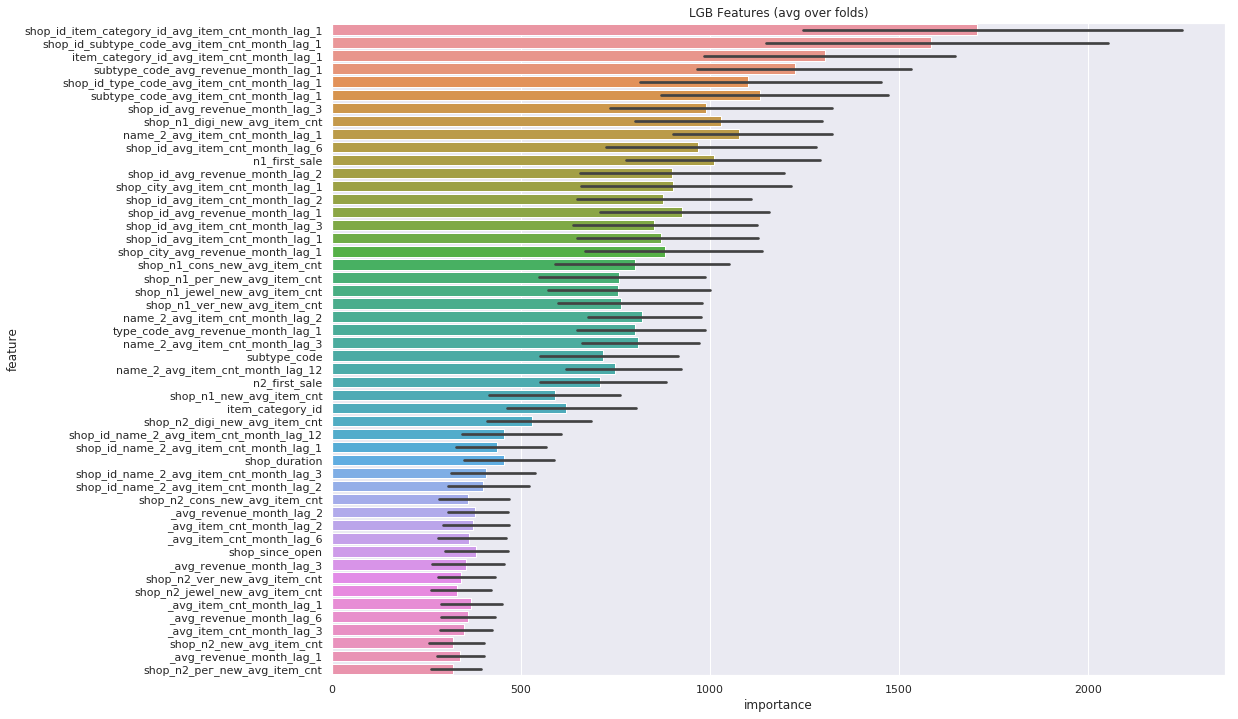

In [27]:
ts = time.time()

result_dict_lgb_0 = train_model_regression(
                         X=X_train.loc[(X_train['item_first_sale']==0)
                                       |((X_train['item_shop_first_sale']==0)) 
                                       ,features_0], 
                         X_test=X_test[features_0], 
                         y=X_train.loc[(X_train['item_first_sale']==0)
                                       |((X_train['item_shop_first_sale']==0)) 
                                       ,'item_cnt_month'], 
                         params=params, 
                         groups = X_train.loc[(X_train['item_first_sale']==0)
                                              |((X_train['item_shop_first_sale']==0)) 
                                              ,'date_block_num'], 
                         folds=folds, model_type='lgb', eval_metric='rmse', plot_feature_importance=True,
                          verbose=500, early_stopping_rounds=200, n_estimators=20000)

time.time()-ts

In [25]:
del train_mix
gc.collect()

10222

In [172]:
feature_importance = result_dict_lgb_0['feature_importance']
feature_importance["importance"] /= folds.n_splits
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[-40:]


Item with sale history

In [ ]:
# 1/10 data items with sale history # 0.6144 0.7354 0.89096  # 0.6267 0.7590 0.88757  
# 1/10 data all items # 0.6847 0.8785 0.88676 # 0.6771 0.8786 0.88560

In [26]:
features_2 = features[:-32]
features_2

['item_category_id',
 'language',
 'isbd',
 'isрегион',
 'isjewel',
 'isdigital',
 'console',
 'has_cd',
 'has_dvd',
 'has_mp3',
 'has_lp',
 'version',
 'type_code',
 'subtype_code',
 'item_cat_id_fix',
 'shop_id_item_id_avg_item_cnt_month_lag_1',
 'shop_id_item_id_avg_item_cnt_month_lag_2',
 'shop_id_item_id_avg_item_cnt_month_lag_3',
 'shop_id_item_id_avg_item_cnt_month_lag_6',
 'shop_id_item_id_avg_revenue_month_lag_1',
 'shop_id_item_id_avg_revenue_month_lag_2',
 'shop_id_item_id_avg_revenue_month_lag_3',
 'shop_id_item_id_avg_revenue_month_lag_6',
 '_avg_item_cnt_month_lag_1',
 '_avg_item_cnt_month_lag_2',
 '_avg_item_cnt_month_lag_3',
 '_avg_item_cnt_month_lag_6',
 '_avg_item_cnt_month_lag_12',
 '_avg_revenue_month_lag_1',
 '_avg_revenue_month_lag_2',
 '_avg_revenue_month_lag_3',
 '_avg_revenue_month_lag_6',
 'item_id_avg_item_cnt_month_lag_1',
 'item_id_avg_item_cnt_month_lag_2',
 'item_id_avg_item_cnt_month_lag_3',
 'item_id_avg_item_cnt_month_lag_6',
 'shop_id_avg_item_cnt_mon

no
Fold 1 started at Tue Feb  4 20:08:41 2020
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 0.7116	valid_1's rmse: 0.849724
[1000]	training's rmse: 0.623876	valid_1's rmse: 0.848284
Early stopping, best iteration is:
[1216]	training's rmse: 0.594524	valid_1's rmse: 0.847729
Fold 2 started at Tue Feb  4 20:12:05 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[195]	training's rmse: 0.7993	valid_1's rmse: 0.826981
Fold 3 started at Tue Feb  4 20:12:55 2020
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 0.704015	valid_1's rmse: 0.886862
Early stopping, best iteration is:
[349]	training's rmse: 0.739658	valid_1's rmse: 0.886134
Fold 4 started at Tue Feb  4 20:13:53 2020
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 0.707104	valid_1's rmse: 0.84711
Early stopping, best iteration is:
[411]	training's rmse: 0.728432	valid

649.8033566474915

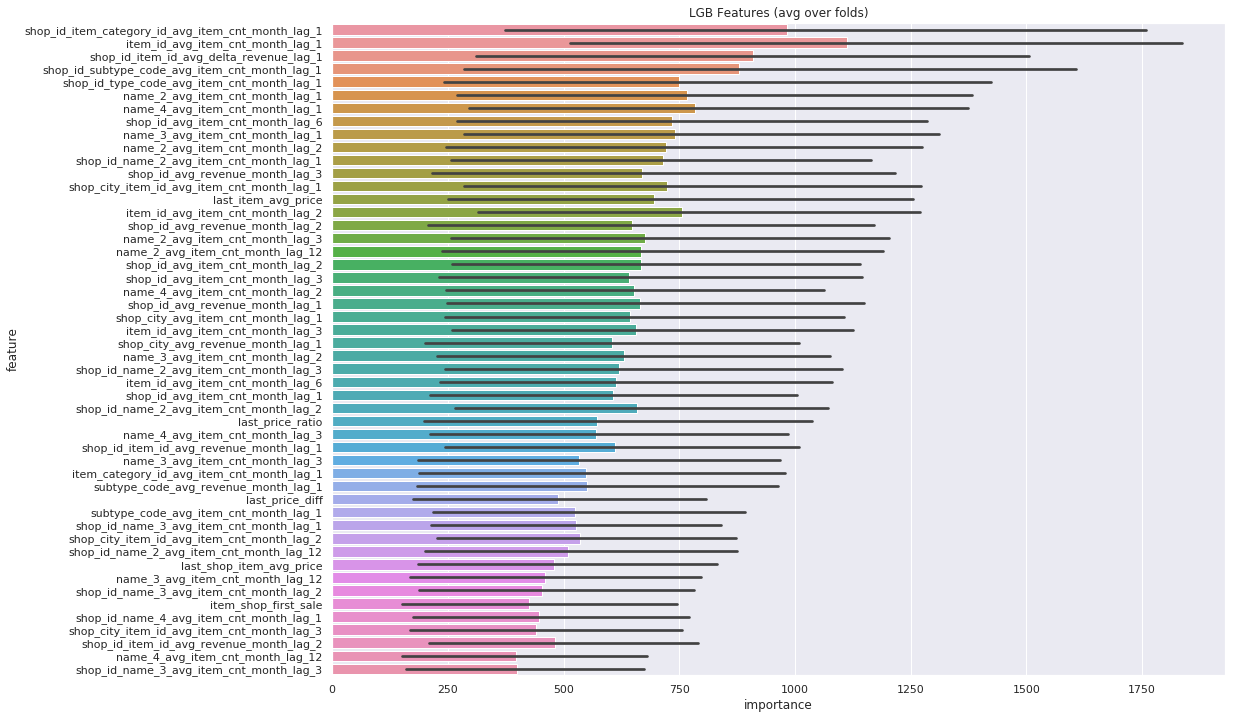

In [29]:
ts = time.time()

result_dict_lgb_2 = train_model_regression(
                 X=X_train[features_2][::10], 
                 X_test=X_test[features_2], 
                 y=X_train['item_cnt_month'][::10], 
                 params=params, 
                 groups = X_train['date_block_num'][::10], 
                 folds=folds, model_type='lgb', eval_metric='rmse', plot_feature_importance=True,
                 verbose=500, early_stopping_rounds=200, n_estimators=20000)

time.time()-ts

# Feature selection

If a feature is important, randomly permutate its values should worse the prediction. We use this logic to select good features

In [24]:
def permutation_importance(X, y_true, model, features):
    perm = {}
    y_pred = model.predict(X[features])
    baseline = root_mean_squared_error(y_true, y_pred)
    count = 1
    features_all = features
        
    for cols in features_all:
        value = X[cols]
        X[cols] = np.random.permutation(X[cols].values)
        y_pred = model.predict(X[features])
        perm[cols] = root_mean_squared_error(y_true, y_pred) - baseline
        
        print(f'Feature_{count}: {cols}, {perm[cols]}')
        
        X[cols] = value
        gc.collect()
        count += 1
    return perm

In [25]:
params = {'num_leaves': 256,                        #  1024   512   256            
          'min_data_in_leaf': 200,                  #  50     100   200           
          'objective': 'huber',                     # huber is the best                        
          'max_depth': -1,                          # 10             -1    
          'learning_rate': 0.3,                    #  0.03   0.3    0.02                     
          "boosting": "gbdt",             
          "bagging_freq": 1,                                    
          "bagging_fraction": 0.7,                  # best: 0.9           0.7                              
          'feature_fraction': 0.5,                  # best: 0.8           0.5
          "bagging_seed": 11,                                    
          "metric": 'rmse',                                       
          "verbosity": -1,                                       
          #'reg_alpha': 0.1,                                    
          #'reg_lambda': 0.05,
          'alpha': 0.5                             # 0.5
         }

In [26]:
def train_model(X_Train, y_Train, X_Valid, y_Valid, features, n_estimators = 20000):
    model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
    model.fit(X_Train, y_Train, 
            eval_set=[(X_Train, y_Train), (X_Valid, y_Valid)], eval_metric='rmse',
            verbose=500, early_stopping_rounds=200)

    return model

In [27]:
def feature_selection(X, y, iteration, features, folds):
    Models = {}
    features_fit = list(features)
    for i in range(iteration + 1):
        print(f'iteration {i}')
        for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
            
            X_Train, X_Valid = X[features_fit].iloc[train_index], X[features_fit].iloc[valid_index]
            y_Train, y_Valid = y.iloc[train_index], y.iloc[valid_index]
            
            model = train_model(X_Train, y_Train, X_Valid, y_Valid, features_fit) 
            perm = permutation_importance(X_Valid, y_Valid, model, features_fit)
                
            features_test = []
            for feature, importance in perm.items():
                
                if importance >= 0:
                    features_test.append(feature)
                    
        if len(features_test) == len(features_fit):
            break
        features_fit = list(features_test)
        
    return features_test, perm

In [ ]:
good_features, perm = feature_selection(X_train[::5],Y_train[::5],10,features,folds)

In [ ]:
perm

# Iterative find best features

One by one select a subset of features that give the best prediction results.

In [88]:
def getDuplicateColumns(df):
    duplicateColumnNames = set()
    goodCol = set()
    
    for x in range(df.shape[1]):
        col = df.iloc[:, x]
        for y in range(x + 1, df.shape[1]):
            otherCol = df.iloc[:, y]
            if col.equals(otherCol):
                found = True
                goodCol.add(df.columns.values[x])
                duplicateColumnNames.add(df.columns.values[y])
            
                
    return list(duplicateColumnNames), list(goodCol)

In [89]:
params = {'num_leaves': 256,                        #  1024   512   256            
          'min_data_in_leaf': 200,                  #  50     100   200           
          'objective': 'huber',                     # huber is the best                        
          'max_depth': -1,                          # 10             -1    
          'learning_rate': 0.3,                    #  0.03   0.3    0.02                     
          "boosting": "gbdt",             
          "bagging_freq": 1,                                    
          "bagging_fraction": 0.7,                  # best: 0.9           0.7                              
          'feature_fraction': 0.5,                  # best: 0.8           0.5
          "bagging_seed": 11,                                    
          "metric": 'rmse',                                       
          "verbosity": -1,                                       
          #'reg_alpha': 0.1,                                    
          #'reg_lambda': 0.05,
          'alpha': 0.5                             # 0.5
         }

In [94]:
n_splits = 2
folds = KFold(n_splits)

In [91]:
features = [feature for feature in train_use.columns.values if feature not in 
           ['date_block_num', 'revenue_month', 'item_cnt_month', 'mean_price', 'missing',
            'category', 
            '1st_pre_cnt_per_month', '2nd_pre_cnt_per_month',
            '1st_pre_item_avg_price','2nd_pre_item_avg_price','1st_2nd_item_price_diff','1st_2nd_item_price_diff_ratio',
            #'item_id_item_cnt_month_enc', 'shop_id_item_cnt_month_enc', 'item_category_id_item_cnt_month_enc'
           ]
           ]

In [ ]:
X_t = X_train[::50]
X_test_t = X_test[:20]
y_t = Y_train[::50]

#features = [col for col in train.columns.values if col not in badcol]
col_tokeep = ['item_id']
scores = [-1.]
duplicate_features, _ = getDuplicateColumns(X_t[features])

for iteration in range(38):
    print(f'Round {iteration}:')
    score_best = 100
    index_best = 0
    number = 0
    for index in range(len(features)):
        if features[index] in col_tokeep:
            continue
        if len(X_t[features[index]].unique()) == 1:
            continue
        if features[index] in duplicate_features:
            continue
            
        print(f'{number} feature {features[index]} started at {time.ctime()}')
        
        number = number + 1
        features_totest = col_tokeep.copy()
        features_totest.append(features[index])
        X_t_t = X_t[features_totest]
        X_test_t_t = X_test_t[features_totest]
        
        result_dict_lgb = train_model_regression(X=X_t_t, X_test=X_test_t_t, y=y_t, 
                                                 params=params, folds=folds, model_type='lgb', eval_metric='rmse', plot_feature_importance=True,
                                                      verbose=200, early_stopping_rounds=200, n_estimators=400)
        score_mean = np.mean(result_dict_lgb['scores'])
        if score_mean < score_best:
            score_best = score_mean
            index_best = index
            
    g.collect()

    col_tokeep.append(features[index_best])
    scores.append(score_best)

In [99]:
gc.collect()

19828508

In [100]:
dict_feature = {'feature': col_tokeep, 'score': scores}
df_features_0 = pd.DataFrame(dict_feature)

In [67]:
#with open('features/result_dict_lgb_2019_12_28.pickle', 'wb') as handle:
#    pickle.dump(df_features_0, handle, protocol = pickle.HIGHEST_PROTOCOL)
    
with open('features/result_dict_lgb_2019_12_28.pickle', 'rb') as handle:
    df_features_0 = pickle.load(handle)

In [ ]:
df_features_0

# Neural network

In [203]:
with open('train_mix_20191108_clip_0_20.pickle', 'rb') as handle:
    train_mix = pickle.load(handle)

In [204]:
train_mix['date_block_num_cp'] = train_mix['date_block_num']

In [205]:
def train_mix_generate_full(df_input):

    df = df_input.copy()
    df_use = df.loc[df['date_block_num'].isin(date)]
    Train_df = df_use[df_use['date_block_num']!= df_use['date_block_num'].max()]
    Test_df = df_use[(df_use['date_block_num']== df_use['date_block_num'].max())&(df_use['category']!=2)]
    
    Train_df[feature_norm] = sc.fit_transform(Train_df[feature_norm])
    Test_df[feature_norm] = sc.transform(Test_df[feature_norm])
    
    Train_df['shop_id'] = Train_df['shop_id'] - shop_min
    #Train['item_id'] = Train['item_id'] - item_min
    Train_df['item_category_id'] = Train_df['item_category_id'] - item_cat_min
    #Train['item_cat_id_fix'] = Train['item_cat_id_fix'] - item_cat_id_fix_min
    Train_df['type_code'] = Train_df['type_code'] - type_code_min
    Train_df['subtype_code'] = Train_df['subtype_code'] - subtype_code_min
    Train_df['city_code'] = Train_df['city_code'] - city_code_min
    Train_df['month'] = Train_df['month'] - month_min

    Test_df['shop_id'] = Test_df['shop_id'] - shop_min
    #Test['item_id'] = Test['item_id'] - item_min
    Test_df['item_category_id'] = Test_df['item_category_id'] - item_cat_min
    #Test['item_cat_id_fix'] = Test['item_cat_id_fix'] - item_cat_id_fix_min
    Test_df['type_code'] = Test_df['type_code'] - type_code_min
    Test_df['subtype_code'] = Test_df['subtype_code'] - subtype_code_min
    Test_df['city_code'] = Test_df['city_code'] - city_code_min
    Test_df['month'] = Test_df['month'] - month_min
    
    X_train = Train_df.loc[Train_df.date_block_num < 33][features]
    Y_train = Train_df.loc[Train_df.date_block_num < 33]['item_cnt_month']
    X_valid = Train_df.loc[Train_df.date_block_num == 33][features]
    Y_valid = Train_df.loc[Train_df.date_block_num == 33]['item_cnt_month']
    X_test = Test_df.loc[Test_df['category']!=2][features]
    
    del Train_df, Test_df
    gc.collect()
    
    return X_train, Y_train, X_valid, Y_valid, X_test, df

In [206]:
X_train, Y_train, X_valid, Y_valid, X_test, train_mix_old = train_mix_generate_full(train_mix)

In [134]:
#del train_normal
gc.collect()

0

In [150]:
train_mix_month = train_mix_0.loc[(train_mix_0['date_block_num'] == 34)&(train_mix_0['category']!=2)]
ratio_1 = len(train_mix_month.loc[train_mix_month["date_shop_cat_avg_item_cnt_lag_1"]==0])/len(train_mix_month)

train_mix_month = train_mix_0.loc[(train_mix_0['date_block_num'] == 34)&(train_mix_0['category']!=2)]
ratio = len(train_mix_month.loc[train_mix_month['date_item_avg_item_cnt_lag_1']==0])/len(train_mix_month)

In [161]:
#"'date_block_num'_'shop_id'_'item_category_id'_avg_item_cnt_month_lag_1"
ratio_month = {}
for month in range(34):
    train_mix_month = train_mix_1.loc[train_mix_1['date_block_num'] == month]
    r = len(train_mix_month.loc[train_mix_month["date_item_avg_item_cnt_lag_1"]==0])/len(train_mix_month)
    ratio_month[month] = r

In [162]:
ratio_month_1 = {}
for month in range(34):
    train_mix_month = train_mix_1.loc[train_mix_1['date_block_num'] == month]
    r_1 = len(train_mix_month.loc[train_mix_month["date_shop_cat_avg_item_cnt_lag_1"]==0])/len(train_mix_month)
    ratio_month_1[month] = r_1

In [1868]:
#ratio_month_1

In [49]:
gc.collect()

0

In [50]:
month_lst = [
 #   1, 2, 3, 4, 5,
    6, 7, 8, 9, 10, 11,
    12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33
]
drop_counter = 0
for month in month_lst:
    if month == 0:
        continue
    train_mix_month = train_mix.loc[train_mix['date_block_num']==month]
    l0 = len(train_mix_month)
    l = len(train_mix_month.loc[train_mix_month["date_item_avg_item_cnt_lag_1"]==0])
    r_month = l / l0
    if r_month < ratio:
        continue
    if np.abs(r_month-ratio) <= 0.02:
        continue
    tmp = train_mix_month.loc[train_mix_month['date_item_avg_item_cnt_lag_1'] == 0]
    target = ratio + np.random.uniform(-0.02, 0.02)
    l_drop = (l0 * target - l) / (target - 1)
    df_drop = tmp.sample(n = int(l_drop))
    train_mix.drop(df_drop.index, axis=0,inplace=True)
    drop_counter += len(df_drop)

In [51]:
gc.collect()

180

In [52]:
features = [feature for feature in train_mix.columns.values if feature not in
           [ 'category', 'revenue_month', 'prediction', 'prediction_0', 'prediction_1', 'item_cnt_month', 'delta_revenue_lag_1',
            'date_shop_type_avg_item_cnt_lag_1', 'date_shop_subtype_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1', 'date_subtype_avg_item_cnt_lag_1',
           'date_block_num'
           ]
           ]

In [1860]:
#features

In [1760]:
bad_cols = [
            "'date_block_num'_'item_category_id'_avg_item_cnt_month_lag_1",       # not so good
            "'date_block_num'_'shop_id'_avg_item_cnt_month_lag_12",
            "'date_block_num'_'subtype_code'_avg_item_cnt_month_lag_1",
            "'date_block_num'_'shop_id'_avg_item_cnt_month_lag_3",
            "'date_block_num'_'shop_id'_'type_code'_avg_item_cnt_month_lag_1",
            "'date_block_num'_'shop_id'_avg_item_cnt_month_lag_2",
            "'date_block_num'_avg_item_cnt_month_lag_1",
            #"'date_block_num'_'item_id'_avg_item_cnt_month_lag_1",                # good
            "'date_block_num'_'city_code'_avg_item_cnt_month_lag_1",
            #"'date_block_num'_'shop_id'_'item_category_id'_avg_item_cnt_month_lag_1",     # good
            "'date_block_num'_'shop_id'_avg_item_cnt_month_lag_6",
            "'date_block_num'_'city_code'_'subtype_code'_avg_item_cnt_month_lag_1",
            #"'date_block_num'_'item_id'_avg_item_cnt_month_lag_3",
            "'date_block_num'_'item_id'_avg_item_cnt_month_lag_12",
            "'date_block_num'_'shop_id'_'subtype_code'_avg_item_cnt_month_lag_1",
            "'date_block_num'_'type_code'_avg_item_cnt_month_lag_1",
            "'date_block_num'_'item_id'_'city_code'_avg_item_cnt_month_lag_1",
            #"'date_block_num'_'item_id'_avg_item_cnt_month_lag_2",
            "'date_block_num'_'city_code'_'item_category_id'_avg_item_cnt_month_lag_1",
            #"'date_block_num'_'item_id'_avg_item_cnt_month_lag_6",
            "'date_block_num'_'city_code'_'type_code'_avg_item_cnt_month_lag_1",
            "'date_block_num'_'shop_id'_avg_item_cnt_month_lag_1",
           ]
#features = list(set(features).difference(bad_cols))

In [53]:
feature_norm = list(set(features).difference(['shop_id', 
                                              #'item_id', 
                                              'item_category_id', 
                                              #'item_cat_id_fix', 
                                              'type_code', 
                                              'subtype_code', 
                                              'city_code', 
                                              'month', 
                                              'date_block_num']))

In [54]:
date = [
#    1, 2, 3, 4, 5, 
    6, 7, 8, 9, 10, 11,
    12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34
]
train_use = train_mix.loc[train_mix['date_block_num'].isin(date)]
from sklearn.preprocessing import StandardScaler
Train = train_use[train_use['date_block_num']!= train_use['date_block_num'].max()]
Test = train_use[(train_use['date_block_num']== train_use['date_block_num'].max())&(train_use['category']!=2)]
sc = StandardScaler()

In [55]:
Train[feature_norm] = sc.fit_transform(Train[feature_norm])
Test[feature_norm] = sc.transform(Test[feature_norm])

shop_min = train_use['shop_id'].min()
#item_min = train_use['item_id'].min()
item_cat_min = train_use['item_category_id'].min()
#item_cat_id_fix_min = train_use['item_cat_id_fix'].min()
type_code_min = train_use['type_code'].min()
subtype_code_min = train_use['subtype_code'].min()
city_code_min = train_use['city_code'].min()
month_min = train_use['month'].min()

Train['shop_id'] = Train['shop_id'] - shop_min
#Train['item_id'] = Train['item_id'] - item_min
Train['item_category_id'] = Train['item_category_id'] - item_cat_min
#Train['item_cat_id_fix'] = Train['item_cat_id_fix'] - item_cat_id_fix_min
Train['type_code'] = Train['type_code'] - type_code_min
Train['subtype_code'] = Train['subtype_code'] - subtype_code_min
Train['city_code'] = Train['city_code'] - city_code_min
Train['month'] = Train['month'] - month_min

Test['shop_id'] = Test['shop_id'] - shop_min
#Test['item_id'] = Test['item_id'] - item_min
Test['item_category_id'] = Test['item_category_id'] - item_cat_min
#Test['item_cat_id_fix'] = Test['item_cat_id_fix'] - item_cat_id_fix_min
Test['type_code'] = Test['type_code'] - type_code_min
Test['subtype_code'] = Test['subtype_code'] - subtype_code_min
Test['city_code'] = Test['city_code'] - city_code_min
Test['month'] = Test['month'] - month_min

In [72]:
X_train = Train.loc[Train.date_block_num < 33][features]
Y_train = Train.loc[Train.date_block_num < 33]['item_cnt_month']
X_valid = Train.loc[Train.date_block_num == 33][features]
Y_valid = Train.loc[Train.date_block_num == 33]['item_cnt_month']
X_test = Test.loc[Test['category']!=2][features]
gc.collect()

113

In [124]:
def train_mix_generate(df_input, random_state):
    month_lst = [
        6, 7, 8, 9, 10, 11,
        12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33
    ]
    drop_counter = 0
    df = df_input.copy()
    for month in month_lst:
        if month == 0:
            continue
        df_month = df.loc[df['date_block_num']==month]
        l0 = len(df_month)
        l = len(df_month.loc[df_month["date_item_avg_item_cnt_lag_1"]==0])
        r_month = l / l0
        if r_month < ratio:
            continue
        if np.abs(r_month-ratio) <= 0.02:
            continue
        tmp = df_month.loc[df_month['date_item_avg_item_cnt_lag_1'] == 0]
        target = ratio + np.random.uniform(-0.02, 0.02)
        l_drop = (l0 * target - l) / (target - 1)
        df_drop = tmp.sample(n = int(l_drop), random_state = random_state)
        df.drop(df_drop.index, axis=0,inplace=True)
        drop_counter += len(df_drop)
        
    df_use = df.loc[df['date_block_num'].isin(date)]
    Train_df = df_use[df_use['date_block_num']!= df_use['date_block_num'].max()]
    Test_df = df_use[(df_use['date_block_num']== df_use['date_block_num'].max())&(df_use['category']!=2)]
    
    Train_df[feature_norm] = sc.fit_transform(Train_df[feature_norm])
    Test_df[feature_norm] = sc.transform(Test_df[feature_norm])
    
    Train_df['shop_id'] = Train_df['shop_id'] - shop_min
    #Train['item_id'] = Train['item_id'] - item_min
    Train_df['item_category_id'] = Train_df['item_category_id'] - item_cat_min
    #Train['item_cat_id_fix'] = Train['item_cat_id_fix'] - item_cat_id_fix_min
    Train_df['type_code'] = Train_df['type_code'] - type_code_min
    Train_df['subtype_code'] = Train_df['subtype_code'] - subtype_code_min
    Train_df['city_code'] = Train_df['city_code'] - city_code_min
    Train_df['month'] = Train_df['month'] - month_min

    Test_df['shop_id'] = Test_df['shop_id'] - shop_min
    #Test['item_id'] = Test['item_id'] - item_min
    Test_df['item_category_id'] = Test_df['item_category_id'] - item_cat_min
    #Test['item_cat_id_fix'] = Test['item_cat_id_fix'] - item_cat_id_fix_min
    Test_df['type_code'] = Test_df['type_code'] - type_code_min
    Test_df['subtype_code'] = Test_df['subtype_code'] - subtype_code_min
    Test_df['city_code'] = Test_df['city_code'] - city_code_min
    Test_df['month'] = Test_df['month'] - month_min
    
    X_train = Train_df.loc[Train_df.date_block_num < 33][features]
    Y_train = Train_df.loc[Train_df.date_block_num < 33]['item_cnt_month']
    X_valid = Train_df.loc[Train_df.date_block_num == 33][features]
    Y_valid = Train_df.loc[Train_df.date_block_num == 33]['item_cnt_month']
    X_test = Test_df.loc[Test_df['category']!=2][features]
    
    del Train_df, Test_df
    gc.collect()
    
    return X_train, Y_train, X_valid, Y_valid, X_test, df

In [128]:
X_train_0, Y_train_0, X_valid_0, Y_valid_0, X_test, train_mix_0 = train_mix_generate(train_mix, 0)

In [135]:
X_train_1, Y_train_1, X_valid_1, Y_valid_1, X_test, train_mix_1 = train_mix_generate(train_mix, 1)

In [166]:
X_train_2, Y_train_2, X_valid_2, Y_valid_2, X_test, train_mix_2 = train_mix_generate(train_mix, 2)

In [57]:
shop_NN = train_use['shop_id'].unique() - train_use['shop_id'].min()
#item_NN = train_use['item_id'].unique() - train_use['item_id'].min()
item_cat_NN = train_use['item_category_id'].unique() - train_use['item_category_id'].min()
#item_cat_fix_NN = train_use['item_cat_id_fix'].unique() - train_use['item_cat_id_fix'].min()
type_NN = train_use['type_code'].unique() - train_use['type_code'].min()
subtype_NN = train_use['subtype_code'].unique() - train_use['subtype_code'].min()
city_NN = train_use['city_code'].unique() - train_use['city_code'].min()
month_NN = train_use['month'].unique() - train_use['month'].min()

In [219]:
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import ReLU, LeakyReLU, BatchNormalization
from keras.layers import Add
from keras.layers import Embedding, concatenate, Reshape
from keras.optimizers import RMSprop, Adam
from keras import backend as K
import tensorflow as tf
import keras

In [220]:
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint

In [240]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

Need to normalize all features

Using embeddings to encode categorical features can improve the prediction. But it can only be as good as lgb

In [241]:
initializer = keras.initializers.RandomUniform(seed=None)
def NN_layers(n_features = 30, dense_features = 220, drop_out = 0.05, embed_dropout = 0.1):
    
    shop_input = Input(shape = (1,))
    #item_input = Input(shape = (1,))
    item_cat_input = Input(shape = (1,))
    #item_cat_fix_input = Input(shape = (1,))
    type_input = Input(shape = (1,))
    subtype_input = Input(shape = (1,))
    city_input = Input(shape = (1,))
    month_input = Input(shape = (1,))
    
    layer_input = Input(shape = (X_train.shape[1] - 6,))
    
    #n_features = 20
    embedding_shop = Embedding(shop_NN.max() + 1, n_features)
    #embedding_item = Embedding(item_NN.max() + 1, n_features)
    embedding_item_cat = Embedding(item_cat_NN.max() + 1, n_features)
    #embedding_item_cat_fix = Embedding(item_cat_fix_NN.max() + 1, n_features)
    embedding_type = Embedding(type_NN.max() + 1, n_features)
    embedding_subtype = Embedding(subtype_NN.max() + 1, n_features)
    embedding_city = Embedding(city_NN.max() + 1, n_features)
    embedding_month = Embedding(month_NN.max() + 1, n_features)
    
    shop = Reshape((-1,))(embedding_shop(shop_input))
    #item = Reshape((-1,))(embedding_item(item_input))
    item_cat = Reshape((-1,))(embedding_item_cat(item_cat_input))
    #item_cat_fix = Reshape((-1,))(embedding_item_cat_fix(item_cat_fix_input))
    Type = Reshape((-1,))(embedding_type(type_input))
    subtype = Reshape((-1,))(embedding_subtype(subtype_input))
    city = Reshape((-1,))(embedding_city(city_input))
    month = Reshape((-1,))(embedding_month(month_input))
    
    #shop = Dropout(0.1)(shop)
    #item = Dropout(0.1)(item)
    #item_cat = Dropout(0.1)(item_cat)
    #item_cat_fix = Dropout(0.1)(item_cat_fix)
    #Type = Dropout(0.1)(Type)
    #subtype = Dropout(0.1)(subtype)
    #city = Dropout(0.1)(city)
    #month = Dropout(0.1)(month)
    
    x = concatenate([shop, 
                     #item, 
                     item_cat, 
                     #item_cat_fix, 
                     Type, 
                     subtype, 
                     city, 
                     month, 
                     layer_input], axis = -1)
    
    x = Dense(dense_features, input_dim=X_train.shape[1], kernel_initializer=initializer, activation='relu')(x)
    #x = Dropout(drop_out)(x)
    
    x = Dense(dense_features, kernel_initializer=initializer)(x)
    #x = BatchNormalization()(x)
    x = ReLU(negative_slope=0.)(x)
    x = Add()([Dense(dense_features, kernel_initializer=initializer)(x), x])
    x = ReLU(negative_slope=0.)(x)
    x = Dropout(drop_out)(x)
    x = Dense(dense_features, kernel_initializer=initializer)(x)
    #x = BatchNormalization()(x)
    x = ReLU(negative_slope=0.)(x)
    x = Add()([Dense(dense_features, kernel_initializer=initializer)(x), x])
    x = ReLU(negative_slope=0.)(x)
    x = Dropout(drop_out)(x)
    x = Dense(dense_features, kernel_initializer=initializer)(x)
    #x = BatchNormalization()(x)
    x = ReLU(negative_slope=0.)(x)
    x = Add()([Dense(dense_features, kernel_initializer=initializer)(x), x])
    x = ReLU(negative_slope=0.)(x)
    x = Dropout(drop_out)(x)
    x = Dense(dense_features, kernel_initializer=initializer)(x)
    #x = BatchNormalization()(x)
    x = ReLU(negative_slope=0.)(x)
    x = Add()([Dense(dense_features, kernel_initializer=initializer)(x), x])
    x = ReLU(negative_slope=0.)(x)
    x = Dropout(drop_out)(x)
    x = Dense(dense_features, kernel_initializer=initializer)(x) 
    #x = BatchNormalization()(x)
    x = ReLU(negative_slope=0.)(x)
    x = Dense(dense_features, kernel_initializer=initializer)(x)
    x = ReLU(negative_slope=0.)(x)
    x = Dropout(drop_out)(x)

    x = Dense(1, kernel_initializer='uniform')(x)
    
    return shop_input, item_cat_input, type_input, subtype_input, city_input, month_input, layer_input, x

In [242]:
# n_features = 30 looks good
shop_input, item_cat_input, type_input, subtype_input, city_input, month_input, layer_input, layer_output = NN_layers(30, 100, 0.2, 0.1)
model_NN = Model([shop_input, item_cat_input, type_input, subtype_input, city_input, month_input, layer_input], layer_output)

In [243]:
lr = 0.00005     # old 0.00005
beta_1 = 0.9
beta_2 = 0.999
#Adam(lr = lr, beta_1 = beta_1, beta_2 = beta_2)
#RMSprop(learning_rate=0.001, rho=0.9)
model_NN.compile(loss='mse', optimizer=Adam(lr = lr, beta_1 = beta_1, beta_2 = beta_2), metrics=['mse'])
checkpointer = ModelCheckpoint(filepath='./models/bestmodel_embedding_mix_2.hdf5', verbose=1, save_best_only=True)

In [244]:
Batch_size =  128                         #best: 1024
Num_Epoch = 10
model_NN.fit([X_train['shop_id'][::20],
              #X_train['item_id'][::10],
              X_train['item_category_id'][::20],
              #X_train['item_cat_id_fix'],
              X_train['type_code'][::20],
              X_train['subtype_code'][::20],
              X_train['city_code'][::20],
              X_train['month'][::20],
              X_train[feature_norm][::20]
             ],
         Y_train[::20],
          batch_size = Batch_size,
          epochs = Num_Epoch,
          validation_data=([X_valid['shop_id'],
                            #X_valid['item_id'],
                            X_valid['item_category_id'],
                            #X_valid['item_cat_id_fix'],
                            X_valid['type_code'],
                            X_valid['subtype_code'],
                            X_valid['city_code'],
                            X_valid['month'],
                            X_valid[feature_norm]
                           ], 
                           Y_valid),
          verbose = 2,
         callbacks = [checkpointer]
         )

Train on 417060 samples, validate on 238172 samples
Epoch 1/10
 - 31s - loss: 0.9363 - mse: 0.9363 - val_loss: 0.8792 - val_mse: 0.8792

Epoch 00001: val_loss improved from inf to 0.87916, saving model to ./models/bestmodel_embedding_mix_2.hdf5
Epoch 2/10
 - 31s - loss: 0.8320 - mse: 0.8320 - val_loss: 0.8506 - val_mse: 0.8506

Epoch 00002: val_loss improved from 0.87916 to 0.85059, saving model to ./models/bestmodel_embedding_mix_2.hdf5
Epoch 3/10
 - 32s - loss: 0.8067 - mse: 0.8067 - val_loss: 0.8404 - val_mse: 0.8404

Epoch 00003: val_loss improved from 0.85059 to 0.84045, saving model to ./models/bestmodel_embedding_mix_2.hdf5
Epoch 4/10
 - 34s - loss: 0.7899 - mse: 0.7899 - val_loss: 0.8399 - val_mse: 0.8399

Epoch 00004: val_loss improved from 0.84045 to 0.83989, saving model to ./models/bestmodel_embedding_mix_2.hdf5
Epoch 5/10
 - 34s - loss: 0.7836 - mse: 0.7836 - val_loss: 0.8300 - val_mse: 0.8300

Epoch 00005: val_loss improved from 0.83989 to 0.82996, saving model to ./model

In [ ]:
0.82523

In [212]:
model_NN.load_weights('./models/bestmodel_embedding_mix_2.hdf5')

In [227]:
Y_test_NN = model_NN.predict([X_test['shop_id'],
                              X_test['item_category_id'],
                              #X_test['item_cat_id_fix'],
                              X_test['type_code'],
                              X_test['subtype_code'],
                              X_test['city_code'],
                              X_test['month'],
                              X_test[feature_norm]
             ])
Y_valid_NN = model_NN.predict([X_valid_0['shop_id'],
                                X_valid_0['item_category_id'],
                                #X_valid['item_cat_id_fix'],
                                X_valid_0['type_code'],
                                X_valid_0['subtype_code'],
                                X_valid_0['city_code'],
                                X_valid_0['month'],
                                X_valid_0[feature_norm]
                           ])

In [93]:
test_submission['prediction_mix_0'] = 0.5

In [94]:
test_submission.loc[test_submission['category']!=2, 'prediction_mix_0'] = Y_test_NN

In [239]:
K.clear_session()
gc.collect()

32

In [1787]:
model_NN.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 1)            0                                            
____________________________________________________________________________________________

# SVR

Much worse compared to lgb or xgb

In [180]:
model = NuSVR(gamma='scale', nu=0.7, tol=0.01, C=1.0)
#oof_svr1, prediction_svr1 = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None, model_type='sklearn', model=model)

In [182]:
#model = model
#model.fit(X_train, Y_train)

y_valid_SVR = model.predict(X_valid).reshape(-1,)
y_test_SVR = model.predict(X_test).reshape(-1,)


In [183]:
score = root_mean_squared_error(Y_valid, y_valid_SVR)
print(f'Score: {score:.4f}.')

Score: 1.0977.


# Iteratively find the best features

In [44]:
import queue as Q
from random import random

In [48]:
def getDuplicateColumns(df):
    duplicateColumnNames = set()
    #goodCol = set()
    
    for x in range(df.shape[1]):
        col = df.iloc[:, x]
        for y in range(x + 1, df.shape[1]):
            otherCol = df.iloc[:, y]
            if col.equals(otherCol):
                #goodCol.add(df.colu)
                duplicateColumnNames.add(df.columns.values[y])
    
    return list(duplicateColumnNames)

In [52]:
def select_features(df, start_features, features_toselect, refine_start, refine_feature, n_features_stop, n_features_calculate, n_Estimators):
    X_t = df
    X_test_t = X_t[:200]
    y_t = X_t['item_cnt_month']
    
    col_tokeep = []
    #features = [col for col in X_t.columns.values]
    if start_features == []:
        col_tokeep = ['city_code']
        scores = [-1.]
    else:
        col_tokeep = list(start_features)
        scores = list(np.zeros(len(start_features)))
        
    duplicate_features = getDuplicateColumns(X_t[features_toselect])
    bad_col = []
    
    for iteration in range(n_features_calculate):
        
        if len(features_toselect) - iteration - len(bad_col) < n_features_stop:
            break
        print(f'Round {iteration + 1}')
        score_best = 100
        index_best = 0
        number = 0
        
        q = Q.PriorityQueue()
        
        for index in range(len(features_toselect)):
            
            if features_toselect[index] in col_tokeep:
                continue
            if len(X_t[features_toselect[index]].unique()) == 1:
                continue
            if features_toselect[index] in duplicate_features:
                continue
            if features_toselect[index] in bad_col:
                continue
                
            value = random()
            if iteration > 15 and value > 0.85:
                continue

            print(f'{number} feature {features_toselect[index]} started at {time.ctime()}')

            number = number + 1
            features_totest = col_tokeep.copy()
            features_totest.append(features_toselect[index])
            X_t_t = X_t[features_totest]
            X_test_t_t = X_test_t[features_totest]

            result_dict_lgb_potential = train_model_regression(X=X_t_t, X_test=X_test_t_t, y=y_t, molecules = None, 
                                     params=params, folds=kf, model_type='lgb', eval_metric='rmse', plot_feature_importance=False,
                                     verbose=500, early_stopping_rounds=200, n_estimators=n_Estimators, groupFold = False)
            score_mean = np.mean(result_dict_lgb_potential['scores'])
            if score_mean < score_best:
                score_best = score_mean
                index_best = index
                
            if iteration > refine_start:
                q.put((-score_mean, index))

        col_tokeep.append(features_toselect[index_best])
        scores.append(score_best)
        if iteration > refine_start and iteration < 25:
            for i in range(refine_feature):
                if not q.empty():
                    temp = q.get()
                    bad_col.append(features_toselect[temp[1]])
                else:
                    break
    dict_feature = {'feature': col_tokeep, 'score': scores}
    df_feature_1J = pd.DataFrame(dict_feature)
    return df_feature_1J, col_tokeep, bad_col

In [54]:
kf = KFold(n_splits = 2, shuffle = False, random_state = 10)

In [50]:
train_testing = train_use.loc[(train_use['date_block_num'] > 13) & (train_use['date_block_num'] <= 33)][::150].copy()

In [16]:
len(train_testing)

38331

In [ ]:
df_feature, col_tokeep, bad_col = select_features(df = train_testing, 
                                                  start_features = [], 
                                                  features_toselect = cols, 
                                                  refine_start = 10, 
                                                  refine_feature = 20, 
                                                  n_features_stop = 0, 
                                                  n_features_calculate = 35, 
                                                  n_Estimators = 400)

In [121]:
with open('bad_col_20191020.pickle', 'wb') as handle:
    pickle.dump(bad_col, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [57]:
df_feature.to_csv('./feature/feature_20191020.csv')

In [17]:
df_feature = pd.read_csv('./feature/feature_20191020.csv')

# Submission

In [50]:
sample_submission = pd.read_csv('./input/sample_submission.csv', 
                                index_col='ID'
                               )
benchmark = sample_submission.copy()
benchmark.reset_index(inplace = True)

In [51]:
submission_1 = pd.read_csv('submissions/submission_20190226_0.csv', 
                                index_col='ID'
                               )
submission_1.reset_index(inplace = True)

In [163]:
#submission_1 = pd.read_csv('submissions/submission_20190204_1.csv', 
#                                index_col='ID'
#                               )
#submission_1.reset_index(inplace = True)

In [19]:
#submission_2 = pd.read_csv('submissions/submission_20190204_1.csv', 
#                                index_col='ID'
#                               )
#submission_2.reset_index(inplace = True)

In [52]:
test = train_mix.loc[train_mix['date_block_num']==34].copy()
test = test[['date_block_num','shop_id','item_id','category']]

In [53]:
test['item_cnt_month_1'] = submission_1['item_cnt_month'].values
#test['item_cnt_month_2'] = submission_2['item_cnt_month'].values
test['item_cnt_month_2'] = result_dict_lgb_0['prediction']

In [54]:
#ratio = 0.7
#test['item_cnt_month'] = test['item_cnt_month_1']*(1-ratio) + test['item_cnt_month_2']*ratio
test['item_cnt_month'] = test['item_cnt_month_1']

In [158]:
test['category_new'] = 4

shop_train = train_use.loc[(train_use['date_block_num']>=6)&(train_use['date_block_num']<=33)]['shop_id'].unique()
item_lst = train_use.loc[(train_use['date_block_num']>=6)&(train_use['date_block_num']<=33)]['item_id'].unique()
#shop_test = test.loc[test['category']==0]['shop_id'].unique()

for shop in shop_train:
    item_lst_shop = train_use.loc[(train_use['date_block_num']>=6)&(train_use['date_block_num']<=33)&(train_use['shop_id'] == shop)]['item_id'].unique()
    test.loc[(test['shop_id'] == shop) & (test['item_id'].isin(item_lst_shop)), 'category_new'] = 0
    
test.loc[~(test['item_id'].isin(item_lst)), 'category_new'] = 2
test.loc[test['shop_id']==36,'category_new']=2

test.loc[test['category_new'] == 4, 'category_new'] = 1

In [44]:
test.loc[test['category']==2,'item_cnt_month']=test.loc[test['category']==2,'item_cnt_month_2']

In [60]:
test.head()

,date_block_num,shop_id,item_id,category,item_cnt_month_1,item_cnt_month_2,item_cnt_month
10842077,34,5,5037,0,0.694902947592472,0.884471385343111,0.694902947592472
10842078,34,5,5320,2,1.884101990018031,1.884101990269444,1.884101990018031
10842079,34,5,5233,0,1.401397534206862,0.628071390589820,1.401397534206862
10842080,34,5,5232,0,0.881177848334276,0.570943063082906,0.881177848334276
10842081,34,5,5268,2,2.461680955944908,2.461680955935782,2.461680955944908


In [46]:
benchmark['item_cnt_month'] = test['item_cnt_month'].values
#.clip(0.0, 20)
benchmark.to_csv('submissions/submission_20190226_1.csv', index=False)
benchmark.head()

,ID,item_cnt_month
0,0,0.694902947592472
1,1,1.553191983978745
2,2,1.401397534206862
3,3,0.881177848334276
4,4,2.392415416258590
